[TFM](https://github.com/jmrplens/TFG-TFM_EPS)

# Diagrama de flujo

<center><img width='600px' src="Data/Data_flow.png"/></center>

Metodología
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=294849

# Métodos

## Carga Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Versión y especificación de directorios

In [2]:
import os

In [3]:
%load_ext autoreload
%autoreload 2


%load_ext tensorboard

In [4]:
from datetime import datetime

MODEL_TIMESTAMP = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")


WEIGHTS_PATH  = './feature_weights/'
REPORTS_PATH  = 'Reports/'
MODELS_PATH   = 'Models/'
F1_SCORES_PATH = 'F1scores/'
GA_SCORES_PATH = 'GA_Scores/'
HYPERPARAMS_PATH = './hyperparams/'

HYPERPARAMS_EVOLUTON_PATH = './hyperparams_evolution/'
FINAL_POPULATION_PATH  = './population/'
CONFUSIONS_MATRIX_PATH = 'confusion_matrix/'
TSNE_PATH = 'tsne/'

REPORTS_TIMES_PATH = 'times/'


###### MODELS ######
MODELS_NAME = ['knn', 'convolution_1d', 'convolution_2d', 'nb', 'svc', 'auto_ml']
MODELS_NAME = ['nb', 'svc', 'knn', 'logistic_regression', 'random_forest', 'mlp', 'convolution_1d', 'convolution_2d', 'auto_ml']

REPORTS_SUMMARY_PATH = f"{REPORTS_PATH}summary/"
######## CONFIG ########
loaded_timestamp = '2023-06-11-13:12:54'

In [5]:
%load_ext autoreload
%autoreload 2

laptop = False
calculate_weights = True
tsne = False

leeds  = False
madrid = False
UK = True

tree_method = 'auto' if laptop else 'gpu_hist'

train_nn = True
other_models = cnn1d = False
cnn1d = True
cnn2d = True
other_models = cnn1d = True

calculate_cnn_hyperparams = False


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# laptop = True
# calculate_weights = True
# tsne = False

# leeds  = False
# madrid = False
# UK = True

# tree_method = 'auto' if laptop else 'gpu_hist'
# # tree_method = 'gpu_hist'
# train_nn = False
# other_models = cnn1d = False

## Importar Tensorflow

In [7]:
# !pip install tensorflow-addons

In [8]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.layers import Input, Lambda, Activation, Conv2D, MaxPooling2D, BatchNormalization, Add, concatenate, Conv2DTranspose, Flatten

2023-07-10 16:23:54.423679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 16:23:54.497201: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 16:23:54.515311: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-10 16:23:54.850926: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [9]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
# !nvidia-smi

Found GPU at: /device:GPU:0


2023-07-10 16:23:55.309094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 16:23:55.426106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 16:23:55.431104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 16:23:55.431186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

## Importador/Exportador JSON

In [10]:
import json

def write_json(feature_vector, root_path, file_name):
    with open(root_path + file_name, 'w') as outfile:
        json.dump(feature_vector, outfile)

def load_json(root_path, file_name):
    with open(root_path + file_name) as json_file:
        data = json.load(json_file)

    return data

## Construcción de imágenes

In [11]:
import numpy as np
import math
from matplotlib import pyplot as plt

def get_feature_matrix_indexes(sorted_feature_vector,matrix):  

    half_row = round((matrix.shape[0] - 1) / 2)
    half_column = round((matrix.shape[1] - 1) / 2)

    matrix_indexes = {}
    
    index = 0

    for parent_key in sorted_feature_vector:
        normalized_index = math.ceil(index/2)

        if (index % 2 != 0): # Impar
            current_row = half_row - normalized_index
        else: # Par
            current_row = half_row + normalized_index

        sorted_child_indexes = np.argsort(feature_vector[parent_key]['feature_weights'])[::-1]

        child_names   = np.array(feature_vector[parent_key]['feature_childs'])
        child_weights = np.array(feature_vector[parent_key]['feature_weights'])

        sorted_child_names   = child_names[sorted_child_indexes]
        sorted_child_weights = child_weights[sorted_child_indexes]

        position = 0
        for sorted_child_index in sorted_child_indexes:
            normalized_position = math.ceil(position/2)

            if (position % 2 != 0): # Impar
                current_column = half_column - normalized_position
            else: # Par
                current_column = half_column + normalized_position

            matrix_indexes[child_names[sorted_child_index]] = [current_row, current_column]
            position = position + 1 

        index = index + 1

    return matrix_indexes
    
def fv2gi(feature_vector):

    max_dimension = 0
    for key in feature_vector:
        childs_number = len(feature_vector[key]['feature_childs'])
        max_dimension = max(childs_number, max_dimension)
                
    matrix = np.zeros((max_dimension, max_dimension))

    weights_vector = []
    for parent_key in feature_vector:
        wpi = sum([float(child_weight) for child_weight in feature_vector[parent_key]['feature_weights']])
        feature_vector[parent_key]['wpi'] = wpi
        weights_vector.append(wpi)

   
    sorted_feature_vector = sorted(feature_vector.items(),
                                   key = lambda item: item[1]['wpi'],
                                   reverse = True)
     
    sorted_feature_vector = dict(sorted_feature_vector)

    
    matrix_indexes = get_feature_matrix_indexes(sorted_feature_vector, matrix)

    return matrix_indexes

# matrix_indexes = fv2gi(feature_vector)

## Construcción Feature Vector

In [12]:
def fill_feature_vector(X_dataset,child_weights):
  # Obtenemos el set de columnas del dataset
  train_columns_set  = set(X_dataset.columns)

  for parent_feature in feature_vector.keys():
    # Obtiene el set de características hijas del padre actual
    # dict.fromleys para mantener el orden, un set desordena los valores
    feature_childs_set = dict.fromkeys(feature_vector[parent_feature]['feature_childs'])

    # Obtener el índice de las columnas del actual padre para acceder a los pesos del XGBoost
    index_feature_childs = X_dataset.columns.get_indexer(feature_childs_set)

    feature_vector[parent_feature]['feature_weights'] = list([str(child_weight) for child_weight in child_weights[index_feature_childs]])

  return feature_vector

## Normalización de datos

In [13]:
from scipy.stats import zscore
import pandas as pd

def normalize_data(X_data):

    # Create a sample df
    normalized_df = X_data

    # Calculate the zscores and drop zscores into new column
    for column in normalized_df.columns:
        normalized_df[column] = zscore(normalized_df[column])
    
    return normalized_df

## Oversampling de datos

In [14]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import KMeansSMOTE

def oversample_data(X_data, Y_labels):

    oversampler = BorderlineSMOTE(kind='borderline-2', random_state = 3)
    # oversampler = RandomOverSampler()
    # oversampler = KMeansSMOTE()
    X_oversampled, Y_oversampled = oversampler.fit_resample(X_data, Y_labels)

    print('********** After OverSampling **********')
    # print('Slight: ', (Y_oversampled == 'Slight').sum())
    # print('Serious:', (Y_oversampled == 'Serious').sum())
    # print('Fatal:  ', (Y_oversampled == 'Fatal').sum())
    # print('\n Total X: ', len(X_oversampled), ' Total Y: ', len(Y_oversampled), '\n')

    print('Slight: ', (Y_oversampled == 'Slight').sum())
    print('Assistance:', (Y_oversampled == 'Assistance').sum())
    print('\n Total X: ', len(X_oversampled), ' Total Y: ', len(Y_oversampled), '\n')

    return X_oversampled, Y_oversampled

## Construcción de imágenes

In [15]:
def build_gray_images(dataset, max_dimension, matrix_indexes):

    matrix_3d = np.zeros((max_dimension, max_dimension, len(dataset.index)))
    print(len(dataset.index))
    for feature, value in matrix_indexes.items():
        matrix_3d[value[0], value[1],] = dataset[feature]
        
    return matrix_3d

## Algoritmo genético

In [16]:
HYPERPARAMS_TO_OPTIMIZE = {'eta': {'type': 'float',
                                   'init': [0.01, 1],
                                   'mutation': [-0.2, 0.2],
                                   'round': 2
                                   },
                           'max_depth': {'type': 'int',
                                         'init': [1, 25],
                                         'mutation': [-3, 3],
                                         'step': 1
                                   },
                           'min_child_weight': {'type': 'float',
                                                'init': [0.01, 20.0],
                                                'mutation': [-4, 4],
                                                'round': 1
                                   }
                          }

number_of_individuals = 50
numberOfParentsMating = 10
number_of_hyperparams = len(HYPERPARAMS_TO_OPTIMIZE)
number_of_generations = 50

### Inicializar población

In [17]:
def generate_individual(hyperparams_to_optimize):

    individual = []

    for key in hyperparams_to_optimize:
        min_value = hyperparams_to_optimize[key]['init'][0]
        max_value = hyperparams_to_optimize[key]['init'][1]
        data_type = hyperparams_to_optimize[key]['type']
        
        if data_type == 'int':
            step = hyperparams_to_optimize[key]['step']
            hyperparam = int(random.randrange(min_value, max_value))

        if data_type == 'float':
            round_to = hyperparams_to_optimize[key]['round']
            hyperparam = round(random.uniform(min_value, max_value), round_to)

        individual.append(hyperparam)
    
    return individual

def initialize_population(number_of_individuals, hyperparams_to_optimize):
    population = []

    for i in range(number_of_individuals):

        population.append(generate_individual(hyperparams_to_optimize))
      
    return np.array(population)

### Fitness function

In [18]:
from sklearn.metrics import f1_score

def fitness_f1score(y_true, y_pred):

    fitness = round((f1_score(y_true, y_pred, average='micro')), 4)

    return fitness # Train the data annd find fitness score

### Evaluación de población

In [19]:
from xgboost import XGBClassifier
import xgboost as xgb
import time

def train_population(population, hyperparams_to_optimize, dMatrixTrain, dMatrixTest, Y_test):

    fScore = []
    
    params = {'objective':'multi:softprob',
              'tree_method': tree_method,
              'single_precision_histogram': True,
              'num_class': 3
             }

    # params = {'objective':'binary:logistic',
    #           'tree_method': tree_method,
    #           'single_precision_histogram': True
    #          }
    for individual_index in range(population.shape[0]):
        # Se almacenan en hyperparams_to_optimize los valores del individuo con su nombre correspondiente de hyperparams_name_to_optimize.
        hyperparams = {}

        for index, hyperparam_value in enumerate(population[individual_index]):

            hyperparam_name_to_optimize = list(hyperparams_to_optimize.keys())[index]
            data_type = hyperparams_to_optimize[hyperparam_name_to_optimize]['type']

            hyperparams[hyperparam_name_to_optimize] = hyperparam_value
            hyperparams[hyperparam_name_to_optimize] = hyperparams[hyperparam_name_to_optimize].astype(data_type)
        
        params.update(hyperparams)

        # num_round = params['n_estimators']
        
        start = time.time()

        xgb.set_config(verbosity = 0)
        bst = xgb.train(params,
                        dMatrixTrain)

        end = time.time()

        preds = bst.predict(dMatrixTest)
        
        single_predictions = [np.argmax(pred) for pred in preds]
        # preds = preds > 0.5
        fitness_score = fitness_f1score(Y_test, single_predictions)

        # print(f"{individual_index}: {hyperparams} --> time(s): {round(end - start, 2)} --> score: {fitness_score}")

        fScore.append(fitness_score)

    return fScore

### Selección de padres

In [20]:
# Select parents for mating
def new_parents_selection(population, fitness, numParents):
    selectedParents = np.empty((numParents, population.shape[1])) # Create an array to store fittest parents.

    for parentId in range(numParents):
        bestFitnessId = np.where(fitness == np.max(fitness))
        bestFitnessId  = bestFitnessId[0][0]
        selectedParents[parentId, :] = population[bestFitnessId, :]
        fitness[bestFitnessId] = -1 # Set this value to negative, in case of F1-score, so this parent is not selected again

    return selectedParents

### Cruzamiento de población

In [21]:
'''
Mate these parents to create children having parameters from these parents (we are using uniform crossover method)
'''
def crossover_uniform(parents, childrenSize):
    
    crossoverPointIndex  = np.arange(0, np.uint8(childrenSize[1]), 1, dtype= np.uint8) # get all the index
    crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]), np.uint8(childrenSize[1]/2)) # select half  of the indexes randomly
    crossoverPointIndex2 = np.array(list(set(crossoverPointIndex) - set(crossoverPointIndex1))) #select leftover indexes
    
    children = np.empty(childrenSize)
    
    '''
    Create child by choosing parameters from two parents selected using new_parent_selection function. The parameter values
    will be picked from the indexes, which were randomly selected above. 
    '''
    for i in range(childrenSize[0]):
        
        #find parent 1 index 
        parent1_index = i%parents.shape[0]
        #find parent 2 index
        parent2_index = (i+1)%parents.shape[0]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]

    return children

### Mutación

In [22]:
def mutation(crossover, hyperparams_to_optimize):
    
    # MUTATION_PROBABILITY = 1/numberOfParameters
    
    MUTATION_PROBABILITY = 0.4
    number_of_parameters = len(hyperparams_to_optimize)

    for idx in range(crossover.shape[0]):

        mutation_probability = np.random.rand(1)

        while MUTATION_PROBABILITY > mutation_probability:

            mutationValue = 0

            hyperparam_selected_index = np.random.randint(0, number_of_parameters)
            hyperparam_selected_name  = list(hyperparams_to_optimize.keys())[hyperparam_selected_index]

            min_limit_value = hyperparams_to_optimize[hyperparam_selected_name]['init'][0]
            max_limit_value = hyperparams_to_optimize[hyperparam_selected_name]['init'][1]

            min_mutation_value = hyperparams_to_optimize[hyperparam_selected_name]['mutation'][0]
            max_mutation_value = hyperparams_to_optimize[hyperparam_selected_name]['mutation'][1]

            data_type = hyperparams_to_optimize[hyperparam_selected_name]['type']
            
            if data_type == 'int':
                step = hyperparams_to_optimize[hyperparam_selected_name]['step']
                mutationValue = int(random.randrange(min_mutation_value, max_mutation_value, step = step))

            if data_type == 'float':
                round_to = hyperparams_to_optimize[hyperparam_selected_name]['round']
                mutationValue = round(random.uniform(min_mutation_value, max_mutation_value), round_to)
                
            # print(idx, hyperparam_selected_name, mutationValue)

            crossover[idx, hyperparam_selected_index] = crossover[idx,hyperparam_selected_index] + mutationValue

            if(crossover[idx, hyperparam_selected_index] > max_limit_value):
                crossover[idx, hyperparam_selected_index] = max_limit_value

            if(crossover[idx, hyperparam_selected_index] < min_limit_value):
                crossover[idx, hyperparam_selected_index] = min_limit_value
                
            mutation_probability = np.random.rand(1)


    return crossover

## Reshape de imágenes

In [23]:
# Add one channel
# https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

# Add one channel to gray images depending of the number of the data
def shape_images(X_data, gray_images):
  images = []

  for i in range(0,len(X_data)):
      original_matrix = gray_images[:,:,i]
      # print(original_matrix.shape)
      shaped_image = np.expand_dims(original_matrix, axis=2)
      # print(shaped_image.shape)
      images.append(shaped_image)
      # plt.matshow(shaped_image)

  return images

## Visualización de datos

### Matriz de correlación

In [24]:
import seaborn as sns

def correlation_matrix(X_data):
    corrMatrix = X_data.corr()
    fig,ax  = plt.subplots(1,1,figsize=(20,15))
    sns.heatmap(corrMatrix, annot=True)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    plt.savefig('saving-a-seaborn-plot-as-eps-file.svg')
    plt.show()


### PCA

In [25]:
from sklearn.decomposition import PCA

def pca(X_train_data, X_test_data):
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train_data)
    X_test_pca  = pca.transform(X_test_data)
    explained_variance = pca.explained_variance_ratio_

    figure_name = plt.figure(figsize=(20, 15))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.savefig('saving-a-seaborn-plot-as-eps-file.svg')
    plt.show()

### TSNE

In [26]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def plot_TSNE(X_data, Y_data, n_components, output_file_name, title):

    # X_data_scaled = StandardScaler().fit_transform(X_data)
    z_data = TSNE(n_components = n_components).fit_transform(X_data)

    # X_test_scaled = StandardScaler().fit_transform(X_test),
    # z_test = TSNE(n_components=2).fit_transform(X_test_scaled),

    palette = sns.color_palette('husl', 3)
    fig,ax  = plt.subplots(1, 1, figsize=(7,4))
    sns.scatterplot(x = z_data[:,0],
                    y = z_data[:,1],
                    hue = Y_data,
                    palette = palette,
                    legend = 'full'
                   ).set(title = title)
    plt.xlabel('Dimension 1', weight = 'bold').set_fontsize('10')
    plt.ylabel('Dimension 1', weight = 'bold').set_fontsize('10')

    if (output_file_name): plt.savefig(output_file_name)

### Autoencoder

In [27]:
def autoencoder ():
    input_img = Input(shape=(25,))

    # definimos el encoder, que tendra una entrada de Input_img y una segunda capa con entrada de encoder1 y salida 3
    encoder1 = layers.Dense(15, activation='sigmoid')(input_img)
    encoder2 = layers.Dense(3, activation='sigmoid')(encoder1)

    # definimos el  decoder que tendra una entrada inicial de encoder3 y una salida de 128 y finalmete una capa de salida con los mismos que Input_img
    decoder1 = layers.Dense(15, activation='sigmoid')(encoder2)
    decoder2 = layers.Dense(25, activation='sigmoid')(decoder1)

    # this model maps an input to its reconstruction
    autoencoder = tf.keras.Model(inputs=input_img, outputs=decoder2)
    autoencoder.summary()

    autoencoder.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)],) #se usan estos dos en estas arquitecturas
    
    return autoencoder

## 1D-Convolution

In [28]:
num_classes = 2

In [29]:


import tensorflow_addons as tfa

lr_init = 0.1

convolution_1d = models.Sequential()
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same', input_shape=(5, 5, 1)))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Conv1D(256, 3, strides = 1, activation='relu', padding='same'))
convolution_1d.add(layers.Flatten())
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Dense(units=128))
convolution_1d.add(layers.BatchNormalization())
convolution_1d.add(layers.Dense(num_classes, activation='softmax'))

convolution_1d.compile(
    optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
    loss='categorical_crossentropy',
    metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
  )



2023-07-10 16:23:56.519901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 16:23:56.520049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 16:23:56.520101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 16:23:56.520318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-10 16:23:56.520381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [30]:
import tensorflow_addons as tfa

def get_1d_conv(fm_one, fm_two, fm_three, fm_four, dense, dropout=0.2, learnRate=0.01):
    cnn_1d_conv = models.Sequential()
    cnn_1d_conv.add(layers.Conv1D(fm_one, 3, strides=1, activation='relu', padding='same', input_shape=(5, 5, 1)))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_two, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_three, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Conv1D(fm_four, 3, strides=1, activation='relu', padding='same'))
    cnn_1d_conv.add(layers.Flatten())
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Dense(units=dense))
    cnn_1d_conv.add(layers.BatchNormalization())
    cnn_1d_conv.add(layers.Dense(2, activation='softmax'))

    cnn_1d_conv.compile(
        optimizer=Adam(learning_rate = learnRate, epsilon=1e-06),
        loss='binary_crossentropy',
        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
    )
    
    return cnn_1d_conv

# convolution_1d.compile(
#     optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
#     loss='categorical_crossentropy',
#     metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
#   )

## TASP-CNN

In [31]:
lr_init = 0.0001

tasp_cnn = models.Sequential()
tasp_cnn.add(layers.Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(5, 5, 1)))
tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 128)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 128)))
tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 128)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 1024)))
tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 32)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(1024, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 512)))
tasp_cnn.add(layers.Dropout(.2,  input_shape=(3, 3, 1024)))
tasp_cnn.add(layers.Flatten())
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Dense(units=32))
tasp_cnn.add(layers.Dropout(.5))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Dense(num_classes, activation='softmax'))

tasp_cnn.compile(
    optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
    loss='binary_crossentropy',
    metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
  )

In [32]:
# def get_tasp_cnn(fm_one, fm_two, fm_three, fm_four, fm_five, fm_six, dense, dropout=0.2, learnRate=0.01):
def get_tasp_cnn_o(fm_one, fm_two, fm_three, fm_four, dense, learning_rate, dropout=0.2):
    tasp_cnn = models.Sequential()
    tasp_cnn.add(layers.Conv2D(fm_one, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(5, 5, 1)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_two, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_one)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_three, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_two)))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Conv2D(fm_four, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, fm_three)))
    tasp_cnn.add(layers.Flatten())
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Dense(units=dense))
    tasp_cnn.add(layers.BatchNormalization())
    tasp_cnn.add(layers.Dense(num_classes, activation='softmax'))

    tasp_cnn.compile(
        optimizer=Adam(learning_rate = learning_rate, epsilon=1e-06),
        loss='binary_crossentropy',
        metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
      )
    
    return tasp_cnn

In [33]:
tasp_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 5, 128)         1280      
                                                                 
 dropout (Dropout)           (None, 5, 5, 128)         0         
                                                                 
 batch_normalization_5 (Batc  (None, 5, 5, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 1024)        1180672   
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 1024)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 5, 5, 1024)       4096      
 hNormalization)                                      

In [34]:
print('Done!')

Done!


## Results

### F1-Score History

In [35]:
def plot_f1_score_history(f1_score_path, f1_score_name, history):
    figure_name = plt.figure(figsize=(20, 10))

    history.history['f1_score'].insert(0, 0)
    history.history['val_f1_score'].insert(0, 0)

    plt.plot(history.history['f1_score'], label='F1 score (training data)')
    plt.plot(history.history['val_f1_score'], label='F1 score (validation data)')
    plt.title('F1 score')
    plt.ylabel('F1 score value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.savefig(f1_score_path + f1_score_name)
    plt.show()
    
    print(history)

### Classification Report

In [36]:
from sklearn.metrics import classification_report

def plot_classification_report(path, file_name, y_true, y_predicted):
    os.makedirs(path, exist_ok = True)

    labels = one_hot_to_casualty(y_true)

    report = classification_report(y_true,
                                   y_predicted,
                                   target_names = labels.unique(),
                                   output_dict  = True)

    report_df = pd.DataFrame(report).transpose().round(3)
    report_df.to_csv(path + file_name, index = True)

    print(report_df)

### Confusion Matrix

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(path, file_name, y_true, y_predicted):
    os.makedirs(path, exist_ok = True)

    cm = confusion_matrix(y_true,
                          y_predicted,
                          labels = y_true.unique())

    labels = one_hot_to_casualty(y_true)

    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = labels.unique()).plot()

    plt.savefig(path + file_name, dpi = 150)

In [38]:
def save_classification_report_and_confussion_matrix(model_name, model_timestamp, y_true, y_predicted, data):
    
    
    report_path = f"{REPORTS_PATH}{model_name}/{data}/"
    report_name = f"{city_name}_{MODEL_NAME}_report_{model_timestamp}.csv"


    plot_classification_report(path = report_path,
                               file_name = report_name,
                               y_true = y_true,
                               y_predicted = y_predicted)


    confussion_matrix_path = f"{CONFUSIONS_MATRIX_PATH}{model_name}/{data}/"
    confussion_matrix_name = f"{city_name}_{MODEL_NAME}_confusion_matrix_{model_timestamp}.svg"

    plot_confusion_matrix(path = confussion_matrix_path,
                          file_name = confussion_matrix_name,
                          y_true = y_true,
                          y_predicted = y_predicted)

In [39]:
print('Done!')

Done!


# UK

In [40]:
loaded_timestamp = '2022-08-02-11:13:09'

## Importación de datos

In [41]:
target_class = 'Casualty Severity'
city = UK

# city_name = 'UK'

config_path = 'config/'
file_name = 'cities_mapper.json'
cities_mapper = load_json(config_path, file_name)

city_to_get = 91
city_name = cities_mapper[str(city_to_get)]

In [42]:
# import pandas as pd

# root_path = './Data/UK'

# # root_path = '/content/drive/Othercomputers/Mi portátil/Drive/Master UA/TFM/Incidentes de Trafico/Datasets/Madrid/'


# years = list(range(2018,2020))

# casualty_dataframe = accidents_dataframe = pd.DataFrame()

# for year in years:
#     aux_dataframe = pd.read_csv(f"{root_path}/{year}/casualty-{year}.csv")
#     casualty_dataframe = pd.concat([casualty_dataframe, aux_dataframe])
    
# for year in years:
#     aux_dataframe = pd.read_csv(f"{root_path}/{year}/accident-{year}.csv")
#     accidents_dataframe = pd.concat([accidents_dataframe, aux_dataframe])
# accidents_dataframe = accidents_dataframe[accidents_dataframe.local_authority_district == 300]
# data_frame = pd.merge(casualty_dataframe, accidents_dataframe, on=['accident_index'])

# years = list(range(2016,2021))
# years = list(range(2009,2017))

# data_frame = pd.read_csv(f"{root_path}/accident-casualty-2005-2020.csv")
# data_frame = pd.read_csv(f"{root_path}/birmingham-accident-casualty-2005-2020.csv")
# data_frame = pd.read_csv(f"{root_path}/leeds-accident-casualty-2005-2020.csv")
# data_frame = pd.read_csv(f"{root_path}/birmingham-accident-casualty-2007-2020.csv")
# data_frame = pd.read_csv(f"{root_path}/birmingham-accident-casualty-2009-2019.csv")
# data_frame = pd.read_csv(f"{root_path}/birmingham-accident-casualty-vehicles-2005-2019.csv")
# # data_frame = pd.read_csv(f"{root_path}/westminster-accident-casualty-vehicles-2005-2019.csv")

# data_frame = data_frame[data_frame.accident_year_x.isin(years)]

# data_frame

In [43]:
import pandas as pd

root_path = './Data/UK'

# #Código para filtrar el archivo 1979-2020 y escribir en disco el dataframe filtrado 2005-2020

years = list(range(2005,2020))

# # # CASUALTY READ, FILTER AND STORE
# casualty_dataframe  = pd.read_csv(f"{root_path}/casualty-1979-2020.csv")

# casualty_dataframe = casualty_dataframe[casualty_dataframe.accident_year.isin(years)]
# casualty_dataframe.to_csv(f"{root_path}/casualty-2005-2019.csv")

casualty_dataframe = pd.read_csv(f"{root_path}/casualty-2005-2019.csv")

# ## ACCIDENTS READ, FILTER AND STORE

chunksize = 1000

# # the list that contains all the dataframes
list_of_dataframes = []

for df in pd.read_csv(f"{root_path}/accident-1979-2020.csv", chunksize=chunksize):
    # process your data frame here
    # then add the current data frame into the list
    list_of_dataframes.append(df[df.accident_year.isin(years)])

# if you want all the dataframes together, here it is
accidents_dataframe = pd.concat(list_of_dataframes)
# Birmingan 300 = Ciudad que queremos
# Cornwall (Londres) 596
# Southwark 596
# Tower 5


accidents_dataframe = accidents_dataframe[accidents_dataframe.local_authority_district == city_to_get]
accidents_dataframe.to_csv(f"{root_path}/{city_to_get}-accident-2005-2019.csv")

# VEHICLES READ, FILTER AND STORE

# chunksize = 1000

# # # the list that contains all the dataframes
# list_of_dataframes = []

for df in pd.read_csv(f"{root_path}/dft-road-casualty-statistics-vehicle-1979-2020.csv", chunksize=chunksize):
    # process your data frame here
    # then add the current data frame into the list
    list_of_dataframes.append(df[df.accident_year.isin(years)])

# # if you want all the dataframes together, here it is
# vehicles_dataframe = pd.concat(list_of_dataframes)
# # 300 = Ciudad que queremos
# vehicles_dataframe.to_csv(f"{root_path}/vehicles-2005-2019.csv")
vehicles_dataframe = pd.read_csv(f"{root_path}/vehicles-2005-2019.csv")

# # # MERGED, DROP DUPLICATES AND STORE
accidents_dataframe['accident_index'] = accidents_dataframe.accident_index.astype('string')
casualty_dataframe['accident_index']  = casualty_dataframe.accident_index.astype('string')
vehicles_dataframe['accident_index']  = vehicles_dataframe.accident_index.astype('string')

data_frame = pd.merge(casualty_dataframe, accidents_dataframe, on=['accident_index'], how='right')
data_frame = pd.merge(vehicles_dataframe, data_frame, on=['accident_index'], how='right')

data_frame = data_frame.drop_duplicates()
data_frame = data_frame.dropna()
data_frame = data_frame.reset_index(drop = True)

data_frame.to_csv(f"{root_path}/{city_name}-accident-casualty-vehicles-2005-2019.csv")

/tmp/ipykernel_21368/3304019657.py:15: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  casualty_dataframe = pd.read_csv(f"{root_path}/casualty-2005-2019.csv")
/tmp/ipykernel_21368/3304019657.py:56: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicles_dataframe = pd.read_csv(f"{root_path}/vehicles-2005-2019.csv")


In [44]:
data_frame = pd.read_csv(f"{root_path}/{city_name}-accident-casualty-vehicles-2005-2019.csv", index_col=[0])

/tmp/ipykernel_21368/184266931.py:1: DtypeWarning: Columns (2,4,31,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frame = pd.read_csv(f"{root_path}/{city_name}-accident-casualty-vehicles-2005-2019.csv", index_col=[0])


In [45]:
# accidents_dataframe.local_authority_district.value_counts()

In [46]:
# data_frame.vehicle_manoeuvre.value_counts()
data_frame.age_of_vehicle.value_counts()

age_of_vehicle
-1     12669
 1      4130
 2      3773
 4      3564
 3      3467
 6      3303
 5      3198
 7      3116
 8      2755
 9      2602
 10     2402
 0      2394
 11     1992
 12     1632
 13     1160
 14      813
 15      564
 16      347
 17      170
 18      131
 19       87
 20       59
 21       25
 24       22
 22       19
 23       17
 25        7
 26        7
 28        5
 34        4
 33        4
 35        3
 27        3
 29        3
 31        2
 37        2
 38        1
Name: count, dtype: int64

In [47]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

data_frame.columns

Index(['Unnamed: 0_x', 'accident_index', 'accident_year', 'accident_reference',
       'vehicle_reference_x', 'vehicle_type', 'towing_and_articulation',
       'vehicle_manoeuvre', 'vehicle_direction_from', 'vehicle_direction_to',
       'vehicle_location_restricted_lane', 'junction_location',
       'skidding_and_overturning', 'hit_object_in_carriageway',
       'vehicle_leaving_carriageway', 'hit_object_off_carriageway',
       'first_point_of_impact', 'vehicle_left_hand_drive',
       'journey_purpose_of_driver', 'sex_of_driver', 'age_of_driver',
       'age_band_of_driver', 'engine_capacity_cc', 'propulsion_code',
       'age_of_vehicle', 'generic_make_model', 'driver_imd_decile',
       'driver_home_area_type', 'Unnamed: 0_y', 'accident_year_x',
       'accident_reference_x', 'vehicle_reference_y', 'casualty_reference',
       'casualty_class', 'sex_of_casualty', 'age_of_casualty',
       'age_band_of_casualty', 'casualty_severity', 'pedestrian_location',
       'pedestrian_moveme

## Limpieza de datos

In [48]:
from src.data import get_to_iso_calendar

data_frame['dia_semana'] = data_frame.apply(lambda row: get_to_iso_calendar(row, 'date').weekday, axis=1)
data_frame['semana_en_año'] = data_frame.apply(lambda row: get_to_iso_calendar(row, 'date').week, axis=1)

In [49]:
from src.data_uk import remove_features

# YES
data_frame = remove_features(data_frame)

In [50]:
print('Before cleaning')
print(f"First Road Class: {data_frame['1st Road Class'].value_counts()}")
print(f"Accident Time: {data_frame['Accident Time'].value_counts()}")
print(f"Number of Vehicles: {data_frame['Number of Vehicles'].value_counts()}")
print(f"Road Surface: {data_frame['Road Surface'].value_counts()}")
print(f"Speed Limit: {data_frame['Speed Limit'].value_counts()}")
print(f"Light Conditions: {data_frame['Lighting Conditions'].value_counts()}")
print(f"Weather Conditions: {data_frame['Weather Conditions'].value_counts()}")
print(f"Type of Vehicle: {data_frame['Type of Vehicle'].value_counts()}")
print(f"Age of Vehicle: {data_frame['Age of Vehicle'].value_counts()}")
print(f"First Point of Impact: {data_frame['First Point of Impact'].value_counts()}")
print(f"Sex of Casualty: {data_frame['Sex of Casualty'].value_counts()}")
print(f"Age of Casualty: {data_frame['Age of Casualty'].value_counts()}")

Before cleaning
First Road Class: 1st Road Class
3    25258
6    22293
4     6085
5      731
1       85
Name: count, dtype: int64
Accident Time: Accident Time
17:30    694
17:00    589
14:00    546
16:00    522
13:00    515
        ... 
05:24      1
02:36      1
21:32      1
01:51      1
22:49      1
Name: count, Length: 1311, dtype: int64
Number of Vehicles: Number of Vehicles
2     36162
3      8349
1      6435
4      2280
5       660
6       294
11       99
7        84
12       48
8        32
9         9
Name: count, dtype: int64
Road Surface: Road Surface
1    39601
2    14052
4      552
3      162
9       62
5       23
Name: count, dtype: int64
Speed Limit: Speed Limit
 30.0    46100
 40.0     6591
 20.0     1508
 50.0      108
 60.0       72
 70.0       71
-1.0         2
Name: count, dtype: int64
Light Conditions: Lighting Conditions
1    39885
4    13933
7      338
5      210
6       86
Name: count, dtype: int64
Weather Conditions: Weather Conditions
1    44101
2     6509
8     

## NOTE
Mirar las diferencias entre clean_before_1(data_frame) y clean_before_2. Si se ejecuta la 1 falla la 2. Parece que hacen cosas diferentes en el tratamiento de los datos. No obstante, parece el código más limpio en el v2. Hay que analizar qué hace cada uno, si ambos tratan todas las columnas de alguna manera y si es así, qué diferencia hay entre ambos. 

In [51]:
data_frame[data_frame.isna().any(axis=1)]

Empty DataFrame
Columns: [Easting, Northing, 1st Road Class, Accident Time, Number of Vehicles, Road Surface, Speed Limit, Lighting Conditions, Weather Conditions, dia_semana, semana_en_año, Type of Vehicle, Age of Vehicle, First Point of Impact, Casualty Class, Sex of Casualty, Age of Casualty, Casualty Severity, longitude, latitude]
Index: []

In [52]:
from src.data_uk import clean_before_1

data_frame = clean_before_1(data_frame)

In [53]:
from src.data_uk import clean_before_2

# clean_df = clean_before_2(data_frame)

In [54]:
print('After cleaning')
print(f"First Road Class: {data_frame['1st Road Class'].value_counts()}")
print(f"Accident Time: {data_frame['Accident Time'].value_counts()}")
print(f"Number of Vehicles: {data_frame['Number of Vehicles'].value_counts()}")
print(f"Road Surface: {data_frame['Road Surface'].value_counts()}")
print(f"Speed Limit: {data_frame['Speed Limit'].value_counts()}")
print(f"Light Conditions: {data_frame['Lighting Conditions'].value_counts()}")
print(f"Weather Conditions: {data_frame['Weather Conditions'].value_counts()}")
print(f"Type of Vehicle: {data_frame['Type of Vehicle'].value_counts()}")
print(f"Age of Vehicle: {data_frame['Age of Vehicle'].value_counts()}")
print(f"First Point of Impact: {data_frame['First Point of Impact'].value_counts()}")
print(f"Sex of Casualty: {data_frame['Sex of Casualty'].value_counts()}")
print(f"Age of Casualty: {data_frame['Age of Casualty'].value_counts()}")

After cleaning
First Road Class: 1st Road Class
3    17561
6    15114
4     4197
5      503
1       63
Name: count, dtype: int64
Accident Time: Accident Time
1    26305
2    11133
Name: count, dtype: int64
Number of Vehicles: Number of Vehicles
2     24874
3      5816
1      4365
4      1592
5       423
6       198
7        56
11       45
12       33
8        27
9         9
Name: count, dtype: int64
Road Surface: Road Surface
1    26841
2    10053
4      413
3      117
5       14
Name: count, dtype: int64
Speed Limit: Speed Limit
30    31536
40     4745
20      965
50       81
60       59
70       52
Name: count, dtype: int64
Light Conditions: Lighting Conditions
1    27566
3     9527
5      156
4      135
2       54
Name: count, dtype: int64
Weather Conditions: Weather Conditions
1    30630
2     4726
8      755
4      550
5      479
3      178
7       98
6       22
Name: count, dtype: int64
Type of Vehicle: Type of Vehicle
9     25465
2      3645
8      2403
11     1745
3      1357
5

In [55]:
# Quitados:

# first_road_class:

# road_surface_conditions:
# 6 -> oil or diesel
# 7 -> Mud -> Lodo
# 9 -> Unknown

# light_conditions:


# weather_conditions:
# 9 -> Unknown

# light_conditions
# 6 -> 2
# 4 -> 3
# 5 -> 4
# 7 -> 5

# casualty_type
# 8 -> 6
# 9 -> 7
# 10 -> 8
# 11 -> 9
# 16 -> 10
# 17 -> 11
# 18 -> 12
# 19 -> 13
# 20 -> 14
# 21 -> 15
# 22 -> 16
# 90 -> 17
# 97 -> 18

# casualty_class

# sex_of_casualty
# 9 UNKNOWN -> DROP?

# age_of_casualty

# TEST

## Filter areas

In [56]:
x_name = 'Easting'
y_name = 'Northing'
casualty_name = 'Casualty Severity'
casualty_target_names = ['Assistance']

In [57]:
data_frame[x_name].min()

332616

In [66]:
# 8
from src.data import remove_outliers

data_frame = remove_outliers(data_frame, x_name, y_name)

In [67]:
from src.data import get_intervals
from src.data import get_divisible_numbers

interval_x, interval_y = get_intervals(data_frame, x_name, y_name)

print('X')
get_divisible_numbers(interval_x)
print('Y')
get_divisible_numbers(interval_y)

X
Area units: 1, regions: 25284.0
Area units: 2, regions: 12642.0
Area units: 3, regions: 8428.0
Area units: 4, regions: 6321.0
Area units: 6, regions: 4214.0
Area units: 7, regions: 3612.0
Area units: 12, regions: 2107.0
Area units: 14, regions: 1806.0
Area units: 21, regions: 1204.0
Area units: 28, regions: 903.0
Area units: 42, regions: 602.0
Area units: 43, regions: 588.0
Area units: 49, regions: 516.0
Area units: 84, regions: 301.0
Area units: 86, regions: 294.0
Area units: 98, regions: 258.0
Area units: 129, regions: 196.0
Area units: 147, regions: 172.0
Area units: 172, regions: 147.0
Area units: 196, regions: 129.0
Area units: 258, regions: 98.0
Area units: 294, regions: 86.0
Area units: 301, regions: 84.0
Area units: 516, regions: 49.0
Area units: 588, regions: 43.0
Area units: 602, regions: 42.0
Area units: 903, regions: 28.0
Area units: 1204, regions: 21.0
Area units: 1806, regions: 14.0
Area units: 2107, regions: 12.0
Area units: 3612, regions: 7.0
Area units: 4214, regions

In [68]:
filename_to_load = f'{city_name}_filtered.csv'


In [69]:
from src.data import get_rows_by_removing_areas

# Birmingan
# x_offset = 211
# y_offset = 75

# Cornwall (UK)
# x_offset = 10
# y_offset = 8

# Southwark
# x_offset = 10 -> regions: 529
# y_offset = 20 -> regions: 487

# Tower
# 6 times remove feaures
# x_offset = 19, regions: 307.0
# y_offset = 25, regions: 246.0

x_offset = 12
y_offset = 21
new_dataframe = get_rows_by_removing_areas(data_frame,
                                           x_name = x_name,
                                           y_name = y_name,
                                           x_offset = x_offset,
                                           y_offset = y_offset,
                                           casualty_name = casualty_name,
                                           casualty_target_names = casualty_target_names)
new_dataframe.to_csv(filename_to_load)

100%|█████████████████████████████████████████| 717/717 [03:24<00:00,  3.51it/s]


In [70]:
new_dataframe = pd.read_csv(filename_to_load, index_col=0)
# new_dataframe.to_csv('test_uk.csv')

In [71]:
new_dataframe

Easting  Northing  1st Road Class  Accident Time  Number of Vehicles   
6340    344610    382660               6              1                   1  \
31817   344188    382692               6              2                   2   
20656   344100    382720               6              1                   1   
6883    343920    382730               6              1                   2   
23596   343690    382760               6              1                   2   
...        ...       ...             ...            ...                 ...   
8218    336840    397580               6              2                   2   
8219    336840    397580               6              2                   2   
8220    336840    397580               6              2                   2   
24832   336841    397587               6              1                   2   
24833   336841    397587               6              1                   2   

       Road Surface  Speed Limit  Lighting Conditions  Weather Conditions   
6340              1           40                    1                   1  \
31817             1           40                    1                   1   
20656             1           30                    1                   1   
6883              2           30                    1                   2   
23596             1           40                    1                   1   
...             ...          ...                  ...                 ...   
8218              1           30                    1                   1   
8219              1           30                    1                   1   
8220              1           30                    1                   1   
24832             2           30                    1                   2   
24833             2           30                    1                   2   

       dia_semana  semana_en_año  Type of Vehicle  Age of Vehicle   
6340            6              9                2               1  \
31817           1             20                3              18   
20656           2             26                2               2   
6883            5             33                3               9   
23596           6             36                3               6   
...           ...            ...              ...             ...   
8218            5             24                9               1   
8219            5             24                9              17   
8220            5             24                9               1   
24832           6             33                6              15   
24833           6             33                6               9   

       First Point of Impact  Casualty Class  Sex of Casualty   
6340                       5               3                1  \
31817                      2               1                1   
20656                      2               3                2   
6883                       2               1                1   
23596                      2               1                1   
...                      ...             ...              ...   
8218                       3               1                1   
8219                       2               2                2   
8220                       3               2                2   
24832                      1               1                1   
24833                      1               1                1   

       Age of Casualty Casualty Severity  longitude   latitude  
6340                 1        Assistance  -2.833336  53.337919  
31817                2        Assistance  -2.839679  53.338163  
20656                1        Assistance  -2.841005  53.338405  
6883                 1        Assistance  -2.843710  53.338475  
23596                3        Assistance  -2.847169  53.338721  
...                ...               ...        ...        ...  
8218                 3            Slight  -2.953004  53.471141  
821

## Plot accidents

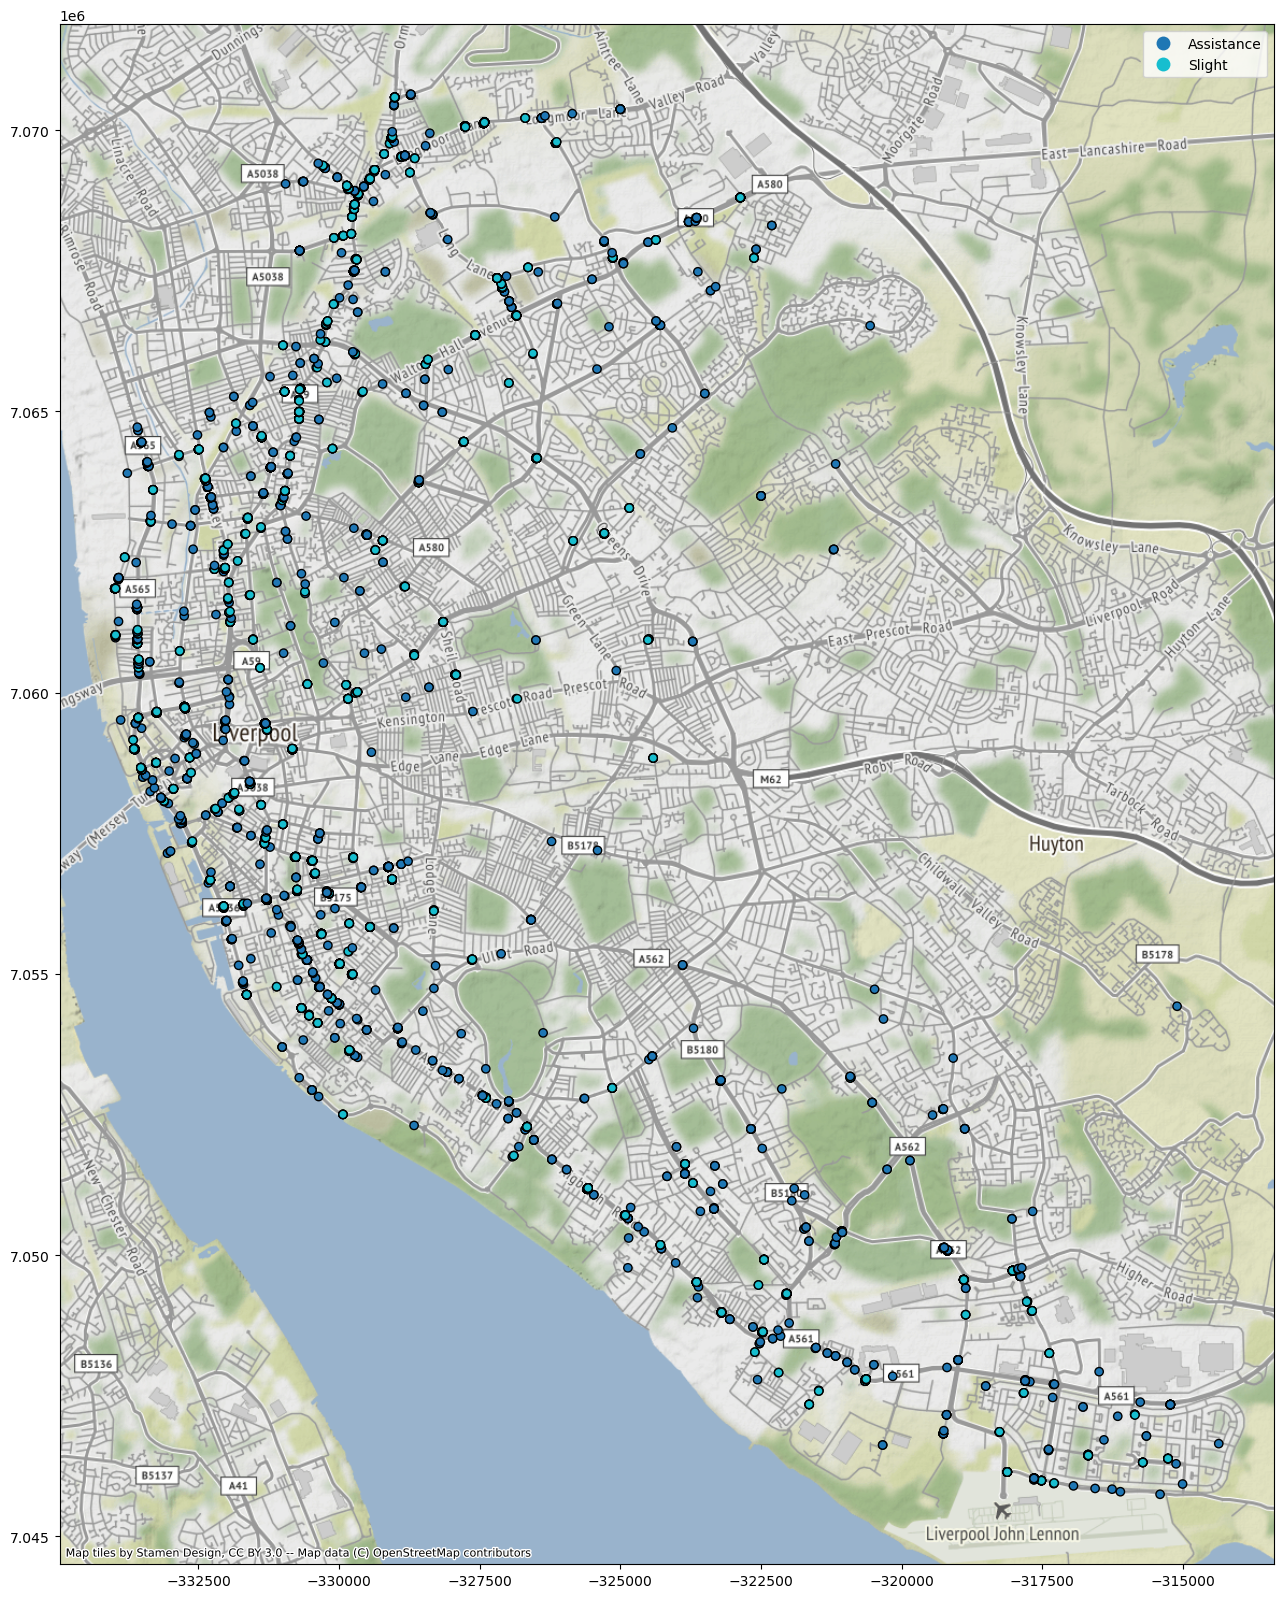

In [72]:
# new_dataframe_2 = new_dataframe[new_dataframe['Casualty Severity'] == 'Assistance']
from src.maps import plot_map

latitude_name  = 'latitude'
longitude_name = 'longitude'

new_dataframe_2 = new_dataframe

plot_map(new_dataframe_2,
         latitude_name = latitude_name,
         longitude_name = longitude_name,
         color_by = casualty_name)


In [73]:
data_frame = new_dataframe_2.loc[:, ~new_dataframe_2.columns.isin(['longitude', 'latitude'])]

# END TEST

## Split de datos

In [74]:
from sklearn.model_selection import train_test_split

Y = data_frame[target_class]

train, test = train_test_split(data_frame, test_size = 0.3)
X_train = X_train_original = train.loc[:, ~train.columns.isin([target_class])]
Y_train = Y_train_original = train[target_class]

X_test = test.loc[:, ~test.columns.isin([target_class])]
Y_test = test[target_class]

<AxesSubplot:>

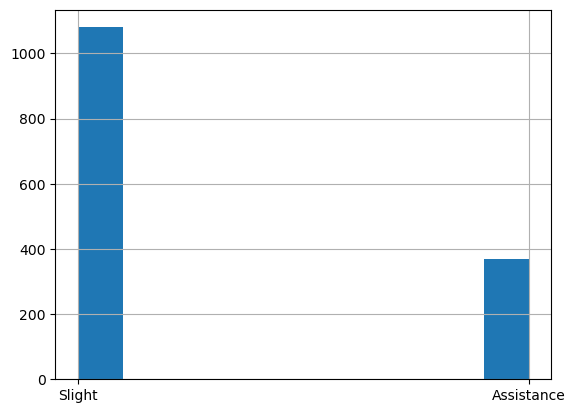

In [75]:
Y_test.hist()

### Downsampling

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

slight_data  = train[train[target_class] == 'Slight']
serious_data = train[train[target_class] == 'Serious']
fatal_data   = train[train[target_class] == 'Fatal']

X_slight_downsampled  = resample(slight_data,
                                 replace = True,
                                 n_samples = len(fatal_data))

X_serious_downsampled = resample(serious_data,
                                 replace = True,
                                 n_samples = len(fatal_data))

downsampled_dataset = pd.concat([X_slight_downsampled, X_serious_downsampled, fatal_data])

# downsampled_train, downsampled_test = train_test_split(downsampled_dataset, test_size=0.2)


X_train_downsampled = downsampled_dataset.loc[:, ~downsampled_dataset.columns.isin([target_class])]
Y_train_downsampled = downsampled_dataset[target_class]

# X_test_downsampled = downsampled_test.loc[:, ~downsampled_test.columns.isin([target_class])]
# Y_test_downsampled = downsampled_test[target_class]

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

if city:
    slight_data  = train[train[target_class] == 'Slight']
    assistance_data = train[train[target_class] == 'Assistance']

    X_slight_downsampled  = resample(slight_data,
                                     replace = True,
                                     n_samples = len(assistance_data))


    downsampled_dataset = pd.concat([X_slight_downsampled, assistance_data])

    # downsampled_train, downsampled_test = train_test_split(downsampled_dataset, test_size=0.2)


    X_train_downsampled = downsampled_dataset.loc[:, ~downsampled_dataset.columns.isin([target_class])]
    Y_train_downsampled = downsampled_dataset[target_class]

    # X_test_downsampled = downsampled_test.loc[:, ~downsampled_test.columns.isin([target_class])]
    # Y_test_downsampled = downsampled_test[target_class]

In [78]:
# fv2gi(feature_vector)
# sorted(feature_vector.items(), key = lambda item: item[0][1])

# for item in feature_vector['Accident Features'].items():
#     print(item[1])

# feature_vector[parent_key].items()

# sorted(feature_vector['Accident Features'].items(), key = lambda item: item,
#                                reverse = True)

# print(feature_vector['Accident Features']['feature_weights'])

# fv = np.array(feature_vector['Accident Features']['feature_childs'])
# list(fv[indexes])

## Normalización de datos

In [79]:
# !conda install -c conda-forge imbalanced-learn

In [80]:
if city:
    X_train = X_train.astype(int)
    X_test  = X_test.astype(int)
    X_train_downsampled = X_train_downsampled.astype(int)
    # X_test_downsampled  = X_test_downsampled.astype(int)

    X_train = normalize_data(X_train)
    X_test  = normalize_data(X_test)
    X_train_downsampled = normalize_data(X_train_downsampled)
    # X_test_downsampled  = normalize_data(X_test_downsampled)

    X_train_original = X_train_original.astype(int)
    X_train_original = normalize_data(X_train_original)

## Oversamplig de datos

In [81]:
# print('********** Train Before OverSampling **********')
# print('Slight: ', (Y_train == 'Slight').sum())
# print('Serious:', (Y_train == 'Serious').sum())
# print('Fatal:  ', (Y_train == 'Fatal').sum())
# print('\n Total X:', len(X_train), ' Total Y:', len(Y_train), '\n')

# X_train, Y_train = oversample_data(X_train, Y_train)

# print('********** Test **********')
# print('Slight: ', (Y_test == 'Slight').sum())
# print('Serious:', (Y_test == 'Serious').sum())
# print('Fatal:  ', (Y_test == 'Fatal').sum())
# print('\n Total X:', len(Y_test), ' Total Y:', len(Y_test), '\n')

In [82]:
if city:
    print('********** Train Before OverSampling **********')
    print('Slight: ', (Y_train == 'Slight').sum())
    print('Assistance:  ', (Y_train == 'Assistance').sum())
    print('\n Total X:', len(X_train), ' Total Y:', len(Y_train), '\n')

    X_train, Y_train = oversample_data(X_train, Y_train)

    print('********** Test **********')
    print('Slight: ', (Y_test == 'Slight').sum())
    print('Assistance:  ', (Y_test == 'Assistance').sum())
    print('\n Total X:', len(Y_test), ' Total Y:', len(Y_test), '\n')

********** Train Before OverSampling **********
Slight:  2560
Assistance:   822

 Total X: 3382  Total Y: 3382 

********** After OverSampling **********
Slight:  2560
Assistance: 2560

 Total X:  5120  Total Y:  5120 

********** Test **********
Slight:  1080
Assistance:   370

 Total X: 1450  Total Y: 1450 



## XGBoost

In [83]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

### Genético

In [84]:
Y_train

0           Slight
1           Slight
2           Slight
3           Slight
4           Slight
           ...    
5115    Assistance
5116    Assistance
5117    Assistance
5118    Assistance
5119    Assistance
Name: Casualty Severity, Length: 5120, dtype: object

In [85]:
from src.data_uk import casualty_to_one_hot
from src.data_uk import one_hot_to_casualty

if city:
    casualty_to_one_hot(Y_train)
    Y_train

In [86]:
# SEVERITY_TYPE_REPLACE = {'Slight': 0,
#                          'Assistance': 1
#                         }

# Y_train.replace(SEVERITY_TYPE_REPLACE, inplace = True)
# Y_train_downsampled.replace(SEVERITY_TYPE_REPLACE, inplace = True)
# Y_test.replace(SEVERITY_TYPE_REPLACE, inplace = True)

In [87]:
import xgboost as xgb
import random

if city and calculate_weights:
    casualty_to_one_hot(Y_train)
    casualty_to_one_hot(Y_train_downsampled)
    casualty_to_one_hot(Y_test)

    populationSize = (number_of_individuals, number_of_hyperparams)
    population = initialize_population(number_of_individuals   = number_of_individuals,
                                       hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

    fitnessHistory = np.empty([number_of_generations+1, number_of_individuals]) # Define an array to store the value of each parameter for each parent and generation
    populationHistory = np.empty([(number_of_generations+1)*number_of_individuals, number_of_hyperparams]) # Insert the value of initial parameters in history

    best_solution_history = np.empty([(number_of_generations), number_of_hyperparams+1])
    populationHistory[0:number_of_individuals,:] = population

    dtrain = xgb.DMatrix(data  = X_train_downsampled,
                         label = Y_train_downsampled)

    dtest  = xgb.DMatrix(data  = X_test, 
                         label = Y_test)

    for generation in range(number_of_generations):

        print("This is number %s generation" % (generation))

        new_population = []

        unique_individuals = np.unique(population, axis=0)

        new_individuals_to_create = number_of_individuals - len(unique_individuals)

        for i in range(new_individuals_to_create):
            new_individual = generate_individual(hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)
            new_population.append(new_individual)

        new_population = np.array(new_population)

        if (new_individuals_to_create):
            population = np.concatenate((unique_individuals, new_population), axis=0)

        # print(f'Current population is {population}')
        print(f'New population is {len(new_population)}')

        # Train the dataset and obtain fitness
        fitnessValue = train_population(population = population,
                                        hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
                                        dMatrixTrain = dtrain,
                                        dMatrixTest = dtest,
                                        Y_test = Y_test)

        fitnessHistory[generation,:] = fitnessValue

        # Best score in the current iteration
        max_score_index = np.argmax(fitnessHistory[generation,:])
        max_score_value = np.max(fitnessHistory[generation,:])
        max_score_solution = population[max_score_index]

        max_solution_with_score = []
        max_solution_with_score = np.append(max_score_solution, max_score_value)
        best_solution_history[generation] = max_solution_with_score

        print(f"Best F1 score in the this iteration = {max_score_value}, best solution {max_score_solution}") # Survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected

        parents = new_parents_selection(population = population,
                                        fitness = fitnessValue,
                                        numParents = numberOfParentsMating)

        # Mate these parents to create children having parameters from these parents (we are using uniform crossover)
        children = crossover_uniform(parents = parents,
                                     childrenSize = (populationSize[0] - parents.shape[0], number_of_hyperparams))

        # Add mutation to create genetic diversity
        children_mutated = mutation(children,
                                    hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE)

        '''
        We will create new population, which will contain parents that where selected previously based on the
        fitness score and rest of them  will be children
        '''
        population[0:parents.shape[0], :] = parents # Fittest parents
        population[parents.shape[0]:, :]  = children_mutated # Children

        populationHistory[(generation+1)*number_of_individuals : (generation+1)*number_of_individuals + number_of_individuals , :] = population # Store parent information

    #Best solution from the final iteration

    fitness = train_population(population = population,
                               hyperparams_to_optimize = HYPERPARAMS_TO_OPTIMIZE,
                               dMatrixTrain = dtrain,
                               dMatrixTest = dtest,
                               Y_test = Y_test)

    fitnessHistory[generation+1, :] = fitness # index of the best solution
    bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]


    best_hyperparams = {}
    for n_param, hyperparam in enumerate(HYPERPARAMS_TO_OPTIMIZE):
        best_hyperparams[hyperparam] = population[bestFitnessIndex][n_param]

This is number 0 generation
New population is 0
Best F1 score in the this iteration = 0.7483, best solution [0.39 1.   7.6 ]
This is number 1 generation
New population is 18
Best F1 score in the this iteration = 0.7483, best solution [0.39 1.   2.5 ]
This is number 2 generation
New population is 21
Best F1 score in the this iteration = 0.7483, best solution [0.38 1.   9.6 ]
This is number 3 generation
New population is 18
Best F1 score in the this iteration = 0.7483, best solution [0.38 1.   7.6 ]
This is number 4 generation
New population is 26
Best F1 score in the this iteration = 0.7483, best solution [0.38 1.   1.4 ]
This is number 5 generation
New population is 32
Best F1 score in the this iteration = 0.7483, best solution [0.38 1.   1.4 ]
This is number 6 generation
New population is 22
Best F1 score in the this iteration = 0.7483, best solution [0.38 1.   1.4 ]
This is number 7 generation
New population is 24
Best F1 score in the this iteration = 0.7483, best solution [0.38 1.  

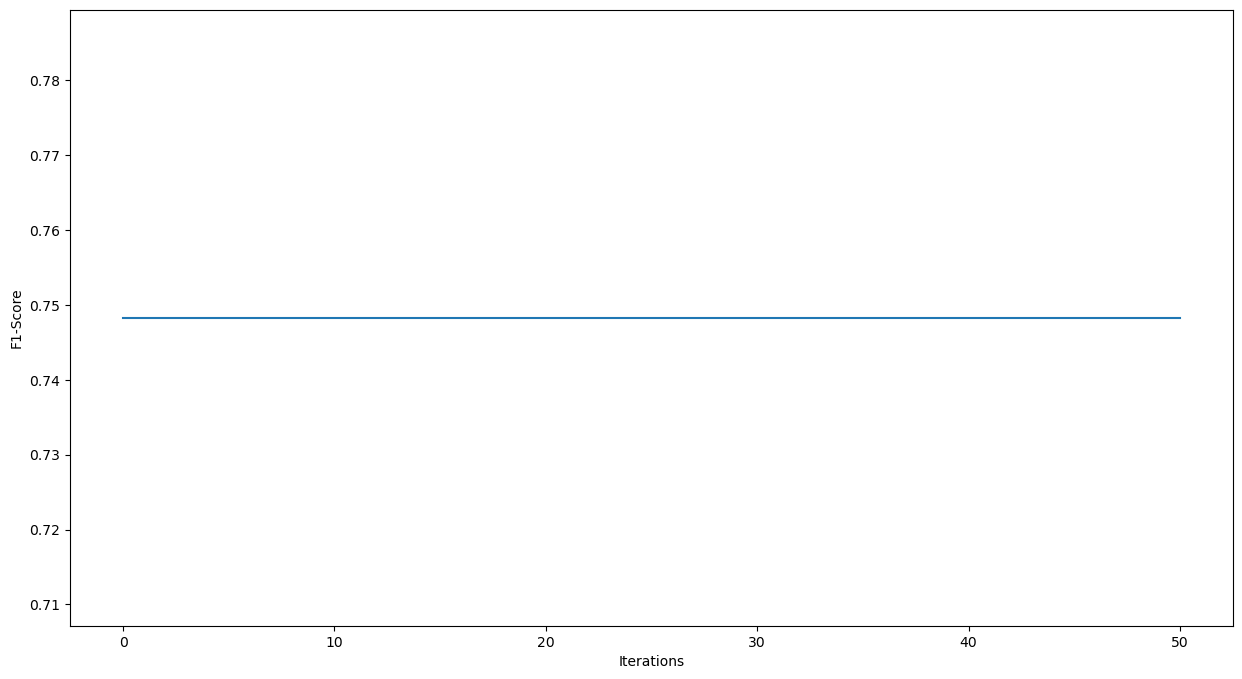

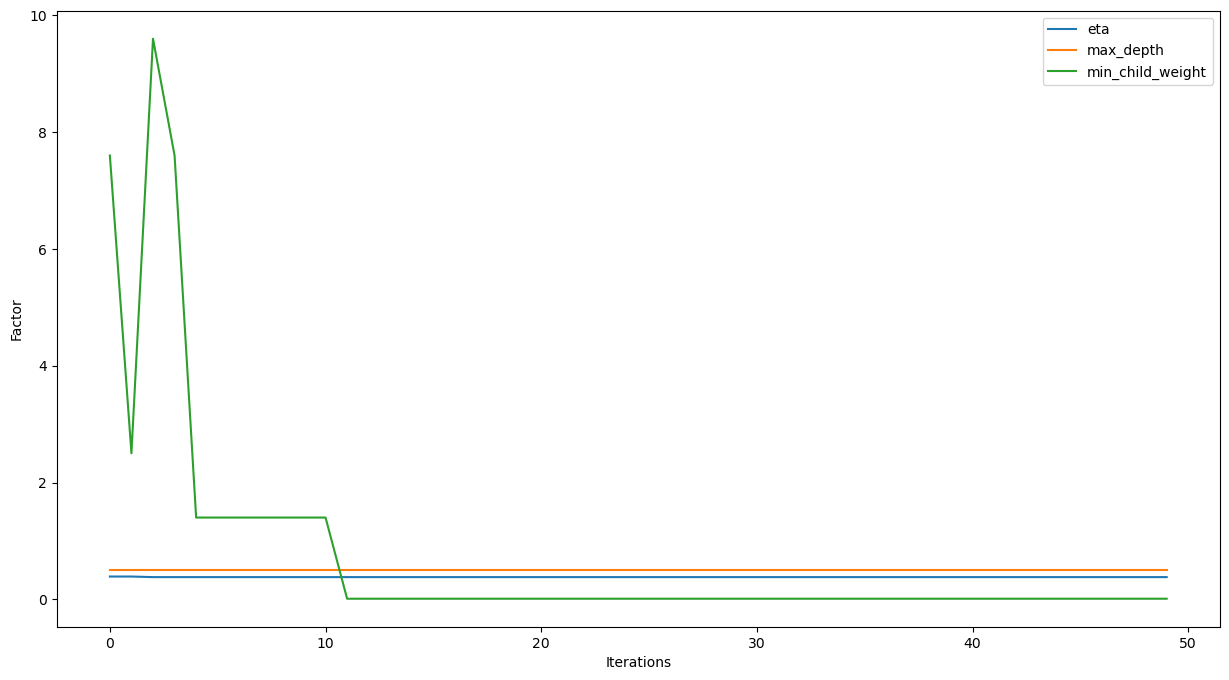

In [88]:
if calculate_weights and city:
    #### PLOT FITNESS EVOLUTION ####
    x_fitness = [np.max(fitnessHistory[i]) for i in range(0,fitnessHistory.shape[0])]

    FILE_NAME = f"{city_name}_ga_{MODEL_TIMESTAMP}.svg"

    plt.figure(figsize=(15, 8))
    plt.ylabel('F1-Score')
    plt.xlabel('Iterations')
    plt.plot(np.arange(len(x_fitness)), x_fitness)
    plt.savefig(GA_SCORES_PATH + FILE_NAME)

    #### PLOT HYPERPARAMS EVOLUTION ####
    FILE_NAME = f"{city_name}_ga_hyperparams_evolution_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.svg"

    LEGEND_LABELS = HYPERPARAMS_TO_OPTIMIZE.keys()

    plt.figure(figsize=(15, 8))
    best_solution_history_aux = best_solution_history
    best_solution_history_aux[:,1] = best_solution_history[:,1]/2
    best_solution_history_aux[:,3] = best_solution_history[:,3]/100
    plt.plot(best_solution_history_aux[:,:3])
    plt.ylabel('Factor')
    plt.xlabel('Iterations')
    plt.legend(LEGEND_LABELS)
    plt.savefig(HYPERPARAMS_EVOLUTON_PATH + FILE_NAME, dpi=300)

    FILE_NAME = f"{city_name}_population_p{number_of_individuals}_c{numberOfParentsMating}_{MODEL_TIMESTAMP}.txt"

    np.savetxt(FINAL_POPULATION_PATH + FILE_NAME, population, fmt='%s')

### Hiperparámetros

#### Carga hiperparámetros

In [89]:
if city and not calculate_weights:
    FILE_NAME = f"{city_name}_hyperparams{loaded_timestamp}.json"

    best_hyperparams = load_json(f"{HYPERPARAMS_PATH}{city_name}/", FILE_NAME)

# # # 0.04 2 6.5 --> 0.778
# best_hyperparams = {}
# best_hyperparams['eta'] = 0.1
# best_hyperparams['max_depth'] = 2
# best_hyperparams['min_child_weight'] = 1
# best_hyperparams['n_estimators'] = 583

# 1.00e-01 2.00e+00 1.00e+00 5.83e+02 --> 0.72

#### Cálculo de Hiperparámetros

In [90]:
# Y_train_onehot = casualty_to_one_hot(Y_train)
# Y_test_onehot  = casualty_to_one_hot(Y_test)

# space={'max_depth': hp.quniform("max_depth", 3, 25, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 15, 1),
#         'n_estimators': hp.quniform('n_estimators', 100, 4000, 100),
#         'tree_method': 'gpu_hist'
#     }

# def objective(space):
#     clf = XGBClassifier(n_estimators = int(space['n_estimators']),
#                         max_depth = int(space['max_depth']),
#                         gamma = space['gamma'],
#                         reg_alpha = int(space['reg_alpha']),
#                         min_child_weight = int(space['min_child_weight']),
#                         colsample_bytree = int(space['colsample_bytree']),
#                         tree_method = space['tree_method']
#                        )
    
#     evaluation = [(X_train, Y_train), (X_test, Y_test)]
    
#     clf.fit(X_train, Y_train,
#             eval_set = evaluation, eval_metric = "auc",
#             early_stopping_rounds = 10, verbose = False)
            
    
#     pred = clf.predict(X_test)
#     accuracy = accuracy_score(Y_test, pred>0.5)
#     print ("SCORE:", accuracy)
#     return {'loss': -accuracy, 'status': STATUS_OK }


# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

#### Escritura hiperparámetros

In [91]:
if calculate_weights and city:
    os.makedirs(f"{HYPERPARAMS_PATH}{city_name}", exist_ok=True)
    FILE_NAME = f"{city_name}_hyperparams{MODEL_TIMESTAMP}.json"

    write_json(best_hyperparams, f"{HYPERPARAMS_PATH}{city_name}/", FILE_NAME)

    print(best_hyperparams)

{'eta': 0.38, 'max_depth': 1.0, 'min_child_weight': 0.01}


### Pesos de características

#### Carga definitiva/auxiliar de pesos

In [92]:
# best_hyperparams['objective'] = 'binary:logistic'
# best_hyperparams.pop('objective')
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])

In [93]:
# '2022-07-06-10:47:41'
loaded_timestamp

'2022-08-02-11:13:09'

In [94]:
if city:
    # FILE_NAME = 'UK_default_weights_mod_3.json'
    FILE_NAME = f"UK_weights_{loaded_timestamp}.json"
    print(FILE_NAME)
    feature_vector = load_json(WEIGHTS_PATH, FILE_NAME)

UK_weights_2022-08-02-11:13:09.json


#### Cálculo de pesos de caracetrísticas

In [95]:
import xgboost as xgb
import random

if calculate_weights and city:
    casualty_to_one_hot(Y_train)

    xgboost = XGBClassifier(obj = 'binary:logistic',
                            **best_hyperparams,
                           
                            tree_method = tree_method,
                            single_precision_histogram =  True)

    xgboost.fit(X_train, Y_train)

    child_weights  = np.array(xgboost.feature_importances_)
    feature_vector = fill_feature_vector(X_train, child_weights)


#### Visualización pesos calculados

{'Easting': 5.0, 'Northing': 4.0, '1st Road Class': 5.0, 'Accident Time': 1.0, 'Number of Vehicles': 15.0, 'Road Surface': 5.0, 'Speed Limit': 1.0, 'Lighting Conditions': 1.0, 'Weather Conditions': 2.0, 'dia_semana': 5.0, 'semana_en_año': 3.0, 'Type of Vehicle': 6.0, 'Age of Vehicle': 5.0, 'First Point of Impact': 11.0, 'Casualty Class': 12.0, 'Sex of Casualty': 8.0, 'Age of Casualty': 11.0}
Easting 0.060890876
Northing 0.028181618
1st Road Class 0.027801761
Accident Time 0.10205669
Number of Vehicles 0.026268138
Road Surface 0.021921087
Speed Limit 0.034279246
Lighting Conditions 0.044700257
Weather Conditions 0.031782687
dia_semana 0.048623223
semana_en_año 0.021929808
Type of Vehicle 0.40217468
Age of Vehicle 0.02417728
First Point of Impact 0.022875955
Casualty Class 0.04496877
Sex of Casualty 0.03450126
Age of Casualty 0.022866717


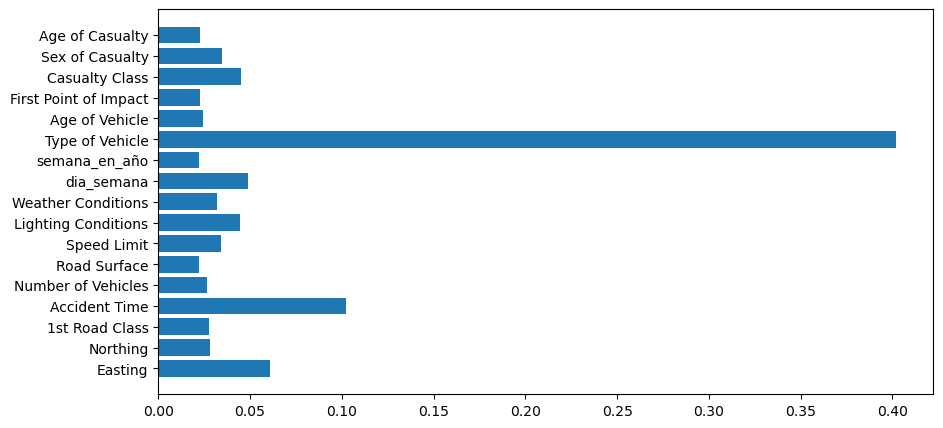

In [96]:
if calculate_weights and city:
    FILE_NAME = f"{city_name}_figure_weights_{MODEL_TIMESTAMP}.svg"

    print(xgboost.get_booster().get_score(importance_type= 'weight'))
    plt.figure(figsize=(10, 5))
    plt.barh(X_train.columns, xgboost.feature_importances_)
    plt.savefig(WEIGHTS_PATH + FILE_NAME)

    for column, weight in zip(X_train.columns,xgboost.feature_importances_):
      print(column, weight)

#### Escritura de pesos de características

In [97]:
# feature_vector

In [98]:
if calculate_weights and city:    
    matrix_indexes = fv2gi(feature_vector)

    FILE_NAME = f"{city_name}_weights_{MODEL_TIMESTAMP}.json"
    # FILE_NAME = 'leeds_default_weights.json'

    write_json(feature_vector, WEIGHTS_PATH, FILE_NAME)

### Cálculo índices de matriz

In [99]:
if city:
    matrix_indexes = fv2gi(feature_vector)

## Construcción de imágenes

In [100]:
if city:
    train_bgi = build_gray_images(X_train, 5, matrix_indexes)
    train_original_bgi = build_gray_images(X_train_original, 5, matrix_indexes)

    test_bgi  = build_gray_images(X_test, 5, matrix_indexes)


    pd.DataFrame(train_bgi[:,:,1057])

5120
3382
1450


## Reshape de imágenes

In [101]:
if city:
    train_images = shape_images(X_data = X_train,
                            gray_images = train_bgi)
    test_images  = shape_images(X_data = X_test,
                                gray_images = test_bgi)


    train_original_images = shape_images(X_data = X_train_original,
                                         gray_images = train_original_bgi)

<Figure size 640x480 with 0 Axes>

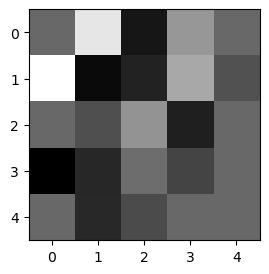

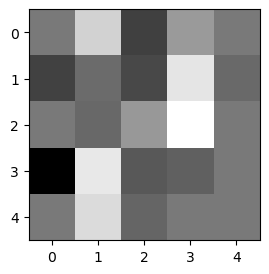

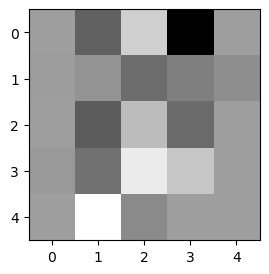

In [102]:
if city:
    plt.gray()
    for i in range(0,3):
        plt.figure(figsize=(3, 3))
        plt.imshow(train_bgi[:,:,i])
        # plt.savefig(f"{city_name}_image_example_{i}.svg",transparent=True)
        plt.show()

In [103]:
MODEL_TIMESTAMP

'2023-07-10-16:23:54'

In [104]:
# image = train_bgi[:,:,0]
# plt.figure(figsize=(6, 6))
# plt.imshow([image.flatten()])
# plt.savefig(f"test.svg",transparent=True, dpi=150)


In [105]:
# !conda install scikit-image

In [106]:
if city:
    # input_shape = (5, 5)

    array_train_images = np.asarray(train_images)
    array_test_images  = np.asarray(test_images)

    array_train_original_images = np.asarray(train_original_images)

In [107]:
# !conda install -c conda-forge tensorflow 

In [108]:
######### EN TERMINAL #########
# !pip install tensorflow-addons

## Visualización de datos

In [109]:
# !conda install seaborn

### Matriz de correlación

In [110]:
# correlation_matrix(X_test)

### PCA

In [111]:
# pca(X_train, X_test)

### TSNE

In [112]:
if city:
    n_samples = 150
    index_slight  = Y_train[Y_train == 'Slight'][:n_samples].index
    index_serious = Y_train[Y_train == 'Serious'][:n_samples].index
    index_fatal   = Y_train[Y_train == 'Fatal'][:n_samples].index

In [113]:
if city:
    # Get same number of class samples from SMOTEII
    X_slight_train_tsne  = X_train.loc[index_slight]
    X_serious_train_tsne = X_train.loc[index_serious]
    X_fatal_train_tsne   = X_train.loc[index_fatal]

    X_train_tsne = pd.concat([X_slight_train_tsne, X_serious_train_tsne, X_fatal_train_tsne])

    Y_slight_train_tsne  = Y_train[index_slight]
    Y_serious_train_tsne = Y_train[index_serious]
    Y_fatal_train_tsne   = Y_train[index_fatal]

    Y_train_tsne = pd.concat([Y_slight_train_tsne, Y_serious_train_tsne, Y_fatal_train_tsne])

In [114]:
if city:
    n_samples = len(Y_train_original[Y_train_original == 'Fatal'])

    index_slight  = Y_train_original[Y_train_original == 'Slight'][:n_samples].index
    index_serious = Y_train_original[Y_train_original == 'Serious'][:n_samples].index
    index_fatal   = Y_train_original[Y_train_original == 'Fatal'][:n_samples].index

In [115]:
if city:
    # Get same number of class samples from original
    X_slight_clean_tsne  = X_train_original.loc[index_slight]
    X_serious_clean_tsne = X_train_original.loc[index_serious]
    X_fatal_clean_tsne   = X_train_original.loc[index_fatal]

    X_clean_tsne = pd.concat([X_slight_clean_tsne, X_serious_clean_tsne, X_fatal_clean_tsne])

    Y_slight_clean_tsne  = Y_train_original[index_slight]
    Y_serious_clean_tsne = Y_train_original[index_serious]
    Y_fatal_clean_tsne   = Y_train_original[index_fatal]

    Y_clean_tsne = pd.concat([Y_slight_clean_tsne, Y_serious_clean_tsne, Y_fatal_clean_tsne])

In [116]:
if tsne and city:
    FILE_NAME = f"{TSNE_PATH}{city_name}/2d_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_clean_tsne, Y_clean_tsne, n_components = 2, output_file_name = FILE_NAME, title = 'Muestras originales 2 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/3d_tsne_test_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_clean_tsne, Y_clean_tsne, n_components = 3, output_file_name = FILE_NAME, title = 'Muestras originales 3 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/2d_tsne_train_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_train_tsne, Y_train_tsne, n_components = 2, output_file_name = FILE_NAME, title = 'Muestras SMOTE-II 2 Componentes')

    FILE_NAME = f"{TSNE_PATH}{city_name}/3d_tsne_train_{MODEL_TIMESTAMP}.svg"
    plot_TSNE(X_train_tsne, Y_train_tsne, n_components = 3, output_file_name = FILE_NAME, title = 'Muestras SMOTE-II 3 Componentes')

### Autoencoder

#### Entrenamiento

In [117]:
# X_train = array_train_images
# X_test = array_test_images
# X_train_original = array_train_original_images

# X_train = X_train.reshape(len(array_train_images), 25)
# X_train_original = X_train_original.reshape(len(array_train_original_images), 25)
# X_test  = X_test.reshape(len(X_test), 25)

# autoencoder = autoencoder().fit(X_train, X_train,
#                                 epochs = 100,
#                                 batch_size = 128,
#                                 shuffle = True,
#                                 validation_data = (X_test, X_test))

#### Visualización

In [118]:
# # create encoder model
# encoder = Model(inputs=input_img, outputs=encoder2)
# encoder.summary()
# # create decoder model
# encoded_input = Input(shape=(3,))
# #lo que hace aqui es quedarse con las capas que corresponden al decodificador
# decoder_layer1 = autoencoder.layers[-2]
# decoder_layer2 = autoencoder.layers[-1]
# decoder = Model(inputs=encoded_input, outputs=decoder_layer2(decoder_layer1(encoded_input)))
# decoder.summary()
# # si miramos la salida, son simetricos el uno respecto al otro
# # encoder va de input a 3 y decoder de 3 a input

# # get latent vector for visualization
# latent_vector = encoder.predict(X_test)
# # # get decoder output to visualize reconstructed image
# # reconstructed_imgs = decoder.predict(latent_vector)


# # visualize in 3D plot
# from pylab import rcParams
# from mpl_toolkits.mplot3d import Axes3D

# rcParams['figure.figsize'] = 10, 8

# fig = plt.figure(1)
# ax = Axes3D(fig)

# xs = latent_vector[:, 0]
# ys = latent_vector[:, 1]
# zs = latent_vector[:, 2]

# color=['red','green','blue']

# for x, y, z, label in zip(xs, ys, zs, Y_test):
#     c = color[int(label)]
#     ax.text(x, y, z, label, backgroundcolor=c)
    
# ax.set_xlim(xs.min(), xs.max())
# ax.set_ylim(ys.min(), ys.max())
# ax.set_zlim(zs.min(), zs.max())

# plt.show()

# # X_test_encoded = encoder.predict(X_test, batch_size=32)
# # plt.figure(figsize=(6, 6))
# # plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test)
# # plt.colorbar()
# # plt.show()

## One-Hot

In [119]:
if city:
    Y_train_onehot = casualty_to_one_hot(Y_train)
    Y_train_original_onehot = casualty_to_one_hot(Y_train_original)
    Y_test_onehot  = casualty_to_one_hot(Y_test)

## Models

In [120]:
if city:
    array_train_images = np.asarray(train_images)
    # array_val_images   = np.asarray(val_images)
    array_test_images  = np.asarray(test_images)

    input_train_shape = (len(array_train_images), 5, 5, 1)
    # input_val_shape = (len(array_val_images), 5, 5, 1)
    input_test_shape  = (len(array_test_images), 5, 5, 1)

    array_train_images = array_train_images.reshape(input_train_shape)
    # array_val_images   = array_val_images.reshape(input_val_shape)
    array_test_images  = array_test_images.reshape(input_test_shape)

    Y_test_labels = one_hot_to_casualty(Y_test)

    from sklearn.utils import class_weight

    pesos = class_weight.compute_class_weight('balanced',
                                              classes = np.unique(Y_train_original),
                                              y = Y_train_original)


    print('\nPesos calculados:', pesos, '\n\n')


    # Keras espera un diccionario donde la clave sea el número de clase 
    # y el valor sea el peso calculado. 
    pesos = dict(enumerate(pesos))  


Pesos calculados: [0.66054687 2.05717762] 




In [121]:
import pickle
from joblib import dump, load

if city:
    times = pd.DataFrame()

### NB

In [122]:
MODEL_NAME = MODELS_NAME[0]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

sns.reset_defaults()

#### Entrenamiento

In [123]:
from sklearn.naive_bayes import GaussianNB

if city and train_nn and other_models:
    start = time.time()

    gnb = GaussianNB()
    gnb = gnb.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])


    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! nb in 0.0 (s)


#### Escritura del modelo

In [124]:
if city and train_nn and other_models:

    dump(gnb, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [125]:
if city and not train_nn and other_models:

    gnb = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [126]:
if city and other_models:
    print("[INFO] evaluating model...")
    if train_nn:
        Y_train_predicted = gnb.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')
    Y_predicted = gnb.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Slight            0.645   0.792     0.711  2560.000
Assistance        0.731   0.565     0.637  2560.000
accuracy          0.679   0.679     0.679     0.679
macro avg         0.688   0.679     0.674  5120.000
weighted avg      0.688   0.679     0.674  5120.000
              precision  recall  f1-score   support
Slight            0.858   0.776     0.815  1080.000
Assistance        0.488   0.624     0.548   370.000
accuracy          0.737   0.737     0.737     0.737
macro avg         0.673   0.700     0.681  1450.000
weighted avg      0.763   0.737     0.747  1450.000


### SVC

In [127]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

MODEL_NAME = MODELS_NAME[1]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [128]:
if city and train_nn and other_models:
    start = time.time()

    clf = SVC(gamma='auto')
    clf.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! svc in 0.34 (s)


#### Escritura del modelo

In [129]:
if city and train_nn and other_models:

    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [130]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    clf = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [131]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:
        Y_train_predicted = clf.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    Y_predicted = clf.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Slight            0.880   0.873     0.876  2560.000
Assistance        0.874   0.881     0.877  2560.000
accuracy          0.877   0.877     0.877     0.877
macro avg         0.877   0.877     0.877  5120.000
weighted avg      0.877   0.877     0.877  5120.000
              precision  recall  f1-score   support
Slight            0.888   0.827     0.856  1080.000
Assistance        0.579   0.695     0.631   370.000
accuracy          0.793   0.793     0.793     0.793
macro avg         0.733   0.761     0.744  1450.000
weighted avg      0.809   0.793     0.799  1450.000


### KNN

In [132]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

MODEL_NAME = MODELS_NAME[2]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

#### Entrenamiento

In [133]:
if city and train_nn and other_models:
    knn = KNeighborsClassifier(leaf_size = 7, n_neighbors = 91)

    start = time.time()

    knn.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

# leaf_size = list(range(1,10, 2))
# n_neighbors = list(range(1,100, 10))
# p = [1, 2]

# if city and train_nn and other_models:

#     start = time.time()

#     # Create new KNN object
#     hyperparameters = dict(leaf_size = leaf_size,
#                            n_neighbors = n_neighbors)

#     # Use GridSearch
#     knn_2 = KNeighborsClassifier(leaf_size = 7, n_neighbors = 91)

#     # Fit the model
#     clf = GridSearchCV(knn_2,
#                        hyperparameters,
#                        cv = 4)

#     knn = clf.fit(X_train, Y_train)

#     end = time.time()

#     ellapsed_time = round(end - start, 2)


#     model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
#     times = times.append(model_time)

#     # Print The value of best Hyperparameters

#     best_leaf_size  = knn.best_estimator_.get_params()['leaf_size']
#     best_n_neighbors = knn.best_estimator_.get_params()['n_neighbors']

#     print('Best leaf_size:', best_leaf_size)
#     print('Best n_neighbors:', best_n_neighbors)

#     df = pd.DataFrame({'best_leaf_size':[best_leaf_size], 'n_neighbors':[best_n_neighbors]})

#     FILE_NAME = f"{MODEL_NAME}/madrid_{MODEL_TIMESTAMP}.csv"

#     df.to_csv(HYPERPARAMS_PATH + FILE_NAME, index = True)

#### Escritura del modelo

In [134]:
if city and train_nn and other_models:

    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.joblib"

    dump(knn, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [135]:
# if city and not train_nn and other_models:

#     version = 'X'
#     MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
#     MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{model_version}.joblib"

#     knn = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [136]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:
        Y_train_predicted = knn.predict(X_train)
        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')
    Y_predicted = knn.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...


/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision  recall  f1-score   support
Slight            0.783   0.627     0.696  2560.000
Assistance        0.689   0.827     0.752  2560.000
accuracy          0.727   0.727     0.727     0.727
macro avg         0.736   0.727     0.724  5120.000
weighted avg      0.736   0.727     0.724  5120.000
              precision  recall  f1-score   support
Slight            0.903   0.627     0.740  1080.000
Assistance        0.424   0.803     0.555   370.000
accuracy          0.672   0.672     0.672     0.672
macro avg         0.663   0.715     0.648  1450.000
weighted avg      0.781   0.672     0.693  1450.000


/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Logistic Regression

In [137]:
from sklearn.linear_model import LogisticRegression

MODEL_NAME = MODELS_NAME[3]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [138]:
train_nn = True

In [139]:
if city and train_nn and other_models:
    start = time.time()

    logistic_regression = LogisticRegression()  
    logistic_regression = logistic_regression.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! logistic_regression in 0.01 (s)


#### Escritura del modelo

In [140]:
if city and train_nn and other_models:

    os.makedirs(MODEL_PATH, exist_ok = True)
    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [141]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    logistic_regression = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [142]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:

        Y_train_predicted = logistic_regression.predict(X_train)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    Y_predicted = logistic_regression.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Slight            0.682   0.769     0.723  2560.000
Assistance        0.735   0.641     0.685  2560.000
accuracy          0.705   0.705     0.705     0.705
macro avg         0.709   0.705     0.704  5120.000
weighted avg      0.709   0.705     0.704  5120.000
              precision  recall  f1-score   support
Slight            0.873   0.754     0.809  1080.000
Assistance        0.486   0.681     0.568   370.000
accuracy          0.735   0.735     0.735     0.735
macro avg         0.680   0.717     0.688  1450.000
weighted avg      0.775   0.735     0.748  1450.000


### Random Forest

In [143]:
from sklearn.linear_model import LogisticRegression

MODEL_NAME = MODELS_NAME[4]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [144]:
if city and train_nn and other_models:
    start = time.time()

    xgboost = XGBClassifier()
    xgboost = XGBClassifier(n_estimators=2, max_depth=2, eta=0.01, min_child_weight= 6.8)
# "eta": 0.01, "max_depth": 2.0, "min_child_weight": 6.8}
    xgboost.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! random_forest in 0.07 (s)


#### Escritura del modelo

In [145]:
if city and train_nn and other_models:
    os.makedirs(MODEL_PATH, exist_ok = True)

    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [146]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    logistic_regression = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [147]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:

        Y_train_predicted = xgboost.predict(X_train)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    Y_predicted = xgboost.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Slight            0.714   0.757     0.735  2560.000
Assistance        0.741   0.696     0.718  2560.000
accuracy          0.727   0.727     0.727     0.727
macro avg         0.727   0.727     0.726  5120.000
weighted avg      0.727   0.727     0.726  5120.000
              precision  recall  f1-score   support
Slight            0.886   0.735     0.804  1080.000
Assistance        0.484   0.724     0.580   370.000
accuracy          0.732   0.732     0.732     0.732
macro avg         0.685   0.730     0.692  1450.000
weighted avg      0.783   0.732     0.747  1450.000


### MLP

In [148]:
from sklearn.neural_network import MLPClassifier

MODEL_NAME = MODELS_NAME[5]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

In [149]:
if city and train_nn and other_models:
    start = time.time()

    clf = MLPClassifier()

    clf.fit(X_train, Y_train)

    end = time.time()

    ellapsed_time = round(end - start, 2)


    model_time = pd.DataFrame({'city': [city_name], 'model': [MODEL_NAME], 'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    print(f"Done! {MODEL_NAME} in {ellapsed_time} (s)")

Done! mlp in 2.65 (s)


/home/luis/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Escritura del modelo

In [150]:
if city and train_nn and other_models:

    dump(clf, MODEL_PATH + MODEL_FILE_NAME) 

#### Carga de modelo pre-entrenado

In [151]:
if city and not train_nn and other_models:
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"

    clf = load(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [152]:
if city and train_nn and other_models:
    print("[INFO] evaluating model...")

    if train_nn:

        Y_predicted = clf.predict(X_train)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_predicted,
                                                         data = 'train')
    Y_predicted = clf.predict(X_test)

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating model...
              precision  recall  f1-score   support
Slight            0.948   0.919     0.933  2560.000
Assistance        0.921   0.950     0.935  2560.000
accuracy          0.934   0.934     0.934     0.934
macro avg         0.935   0.934     0.934  5120.000
weighted avg      0.935   0.934     0.934  5120.000
              precision  recall  f1-score   support
Slight            0.875   0.832     0.853  1080.000
Assistance        0.571   0.651     0.609   370.000
accuracy          0.786   0.786     0.786     0.786
macro avg         0.723   0.742     0.731  1450.000
weighted avg      0.797   0.786     0.791  1450.000


### Convolution 1D

In [153]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [154]:
MODEL_NAME = MODELS_NAME[6]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

#### Entrenamiento

In [155]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [156]:
if city and train_nn and not calculate_cnn_hyperparams:
    
    fm_one, fm_two, fm_three, fm_four = (64, 512, 128, 256)
    n_classes = Y_train.unique()

    dense  = 256

    learnRate = 0.001

    batchSize = 64

    start = time.time()

    convolution_1d =  get_1d_conv(fm_one = fm_one,
                           fm_two = fm_two,
                           fm_three = fm_three,
                           fm_four = fm_four,
                           dense = dense,
                           dropout = 0.2,
                           learnRate = learnRate)

    history = convolution_1d.fit(array_train_images, Y_train_onehot,
                                   # class_weight = pesos,
                                   batch_size = batchSize,
                                   epochs = 500,
                                   shuffle = True,
                                   validation_data = (array_test_images, Y_test_onehot),
                                   callbacks=[tensorboard_callback])

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': [ellapsed_time]})

    times = pd.concat([times, model_time])

    history

Epoch 1/500


2023-07-10 16:33:30.233057: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


19/80 [======>.......................] - ETA: 0s - loss: 1.0228 - f1_score: 0.7055  

2023-07-10 16:33:30.595157: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-07-10 16:33:30.596033: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-07-10 16:33:30.596064: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-07-10 16:33:30.596099: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-07-10 16:33:30.638060: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] Tensor

80/80 [==============================] - 2s 10ms/step - loss: 0.6367 - f1_score: 0.7505 - val_loss: 2.0969 - val_f1_score: 0.2552
Epoch 2/500
80/80 [==============================] - 1s 8ms/step - loss: 0.4542 - f1_score: 0.7817 - val_loss: 3.6202 - val_f1_score: 0.2552
Epoch 3/500
80/80 [==============================] - 1s 7ms/step - loss: 0.4297 - f1_score: 0.7941 - val_loss: 5.0220 - val_f1_score: 0.2552
Epoch 4/500
80/80 [==============================] - 1s 8ms/step - loss: 0.4283 - f1_score: 0.7981 - val_loss: 4.3947 - val_f1_score: 0.2552
Epoch 5/500
80/80 [==============================] - 1s 9ms/step - loss: 0.4092 - f1_score: 0.8043 - val_loss: 2.7577 - val_f1_score: 0.2600
Epoch 6/500
80/80 [==============================] - 1s 8ms/step - loss: 0.3981 - f1_score: 0.8071 - val_loss: 1.7249 - val_f1_score: 0.4171
Epoch 7/500
80/80 [==============================] - 1s 8ms/step - loss: 0.3878 - f1_score: 0.8130 - val_loss: 0.7362 - val_f1_score: 0.7013
Epoch 8/500
80/80 [=====

In [157]:
# if city and train_nn and cnn1d and not calculate_cnn_hyperparams:
#     start = time.time()

#     fold_no = 1
#     # for train, test in kfold.split(inputs, targets):
#     history = convolution_1d.fit(array_train_images, Y_train_onehot,
#                                  # class_weight = pesos,
#                                  batch_size = 64,
#                                  epochs = 100,
#                                  shuffle = True,
#                                  validation_data = (array_test_images, Y_test_onehot))
#     end = time.time()

#     ellapsed_time = round(end - start, 2)

#     model_time = pd.DataFrame({'city': [city_name],
#                                'model': [MODEL_NAME],
#                                'time': [ellapsed_time]})

#     times = times.append(model_time)

#     history

In [158]:
# if city and train_nn and not calculate_cnn_hyperparams:
    
#     fm_one, fm_two, fm_three, fm_four = (64, 512, 1024, 512)
#     n_classes = Y_train.unique()

#     dense  = 32

#     learnRate = 0.001

#     batchSize = 32

#     start = time.time()

#     convolution_1d = get_1d_conv(fm_one = fm_one,
#                            fm_two = fm_two,
#                            fm_three = fm_three,
#                            fm_four = fm_four,
#                            dense = dense,
#                            dropout = 0.2,
#                            learnRate = learnRate)

#     history = convolution_1d.fit(array_train_images, Y_train_onehot,
#                            # class_weight = pesos,
#                            batch_size = batchSize,
#                            epochs = 1,
#                            shuffle = True,
#                            validation_data = (array_test_images, Y_test_onehot))

#     end = time.time()

#     ellapsed_time = round(end - start, 2)

#     model_time = pd.DataFrame({'city': [city_name],
#                                'model': [MODEL_NAME],
#                                'time': [ellapsed_time]})
#     times = times.append(model_time)    

#     history

In [159]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

if city and train_nn and calculate_cnn_hyperparams:

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': 0})
    times = times.append(model_time)
    # wrap our model into a scikit-learn compatible classifier
    print("[INFO] initializing model...")
    model = KerasClassifier(build_fn=get_1d_conv, verbose=10)

    # define a grid of the hyperparameter search space

    # fm_one = fm_two = fm_three = fm_four = fm_five = fm_six = [32, 64, 128, 256, 512]
    fm_one = fm_two = fm_three = fm_four = [32, 64, 128, 256, 512, 1024]

    dense  = [32, 64, 128, 256]

    learnRate = [0.1, 1e-2, 1e-3, 1e-4]

    batchSize = [32, 64, 128]

    epochs = [60]

    # create a dictionary from the hyperparameter grid
    grid = dict(
        fm_one = fm_one,
        fm_two = fm_two,
        fm_three = fm_three,
        fm_four = fm_four,
        dense = dense,
        learnRate=learnRate,
        batch_size=batchSize,
        epochs=epochs
    )

    # initialize a random search with a 3-fold cross-validation and then
    # start the hyperparameter search process
    print("[INFO] performing random search...")
    searcher = RandomizedSearchCV(estimator = model,
                                  n_iter = 50,
                                  cv = 3,
                                  param_distributions = grid,
                                  scoring = 'f1_micro')

    searchResults = searcher.fit(array_train_images, Y_train)

    # summarize grid search information
    bestScore = searchResults.best_score_
    bestParams = searchResults.best_params_

    print("[INFO] best score is {:.2f} using {}".format(bestScore,	bestParams))

    print("[INFO] evaluating the best model...")
    convolution1d = bestModel = searchResults.best_estimator_
    # accuracy = bestModel.score(array_test_images, Y_test)
    # print("accuracy: {:.2f}%".format(accuracy * 100))

    text_file = open(f"./CNN1D-{MODEL_TIMESTAMP}.txt", "w")
    n = text_file.write(str(searchResults.cv_results_))
    text_file.close()

#### Escritura del modelo

In [160]:
if city and train_nn and cnn1d:

    convolution_1d.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [161]:
if city and not train_nn and not laptop and cnn1d:
    # MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{loaded_timestamp}.h5"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_2022-07-19-08:49:34.h5"
    # MODEL_FILE_NAME = 'madrid_convolution_1d_2022-05-19-06:33:55.h5'

    convolution_1d = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

#### Resultados

In [162]:
if city and cnn1d:

    print("[INFO] evaluating network...")

    Y_predicted = convolution_1d.predict(x = array_test_images).argmax(axis = 1)

    if train_nn:
        F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
        F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.svg"

        # plot_f1_score_history(f1_score_path = F1_SCORE_PATH,
        #                       f1_score_name = F1_SCORE_NAME,
        #                       history = history)

        Y_train_predicted = convolution_1d.predict(x = array_train_images).argmax(axis = 1)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')

[INFO] evaluating network...
160/160 [==============================] - 0s 2ms/step
              precision  recall  f1-score   support
Slight            0.964   0.967     0.965  2560.000
Assistance        0.967   0.964     0.965  2560.000
accuracy          0.965   0.965     0.965     0.965
macro avg         0.965   0.965     0.965  5120.000
weighted avg      0.965   0.965     0.965  5120.000
              precision  recall  f1-score   support
Slight            0.913   0.706     0.796  1080.000
Assistance        0.484   0.803     0.604   370.000
accuracy          0.731   0.731     0.731     0.731
macro avg         0.698   0.755     0.700  1450.000
weighted avg      0.803   0.731     0.747  1450.000


### Convolution 2D

In [163]:
MODEL_NAME = MODELS_NAME[7]

MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

#### Entrenamiento

In [164]:
if city and train_nn and not calculate_cnn_hyperparams:
    
    fm_one, fm_two, fm_three, fm_four = (64, 512, 1024, 512)
    n_classes = Y_train.unique()

    dense  = 32

    learning_rate = 0.001

    batchSize = 32

    start = time.time()

    tasp_cnn = get_tasp_cnn_o(fm_one = fm_one,
                            fm_two = fm_two,
                            fm_three = fm_three,
                            fm_four = fm_four,
                            dense = dense,
                            dropout = 0.2,
                            learning_rate = learning_rate)

    history = tasp_cnn.fit(array_train_images, Y_train_onehot,
                           # class_weight = pesos,
                           batch_size = batchSize,
                           epochs = 50,
                           shuffle = True,
                           validation_data = (array_test_images, Y_test_onehot),
                           callbacks=[tensorboard_callback])

    end = time.time()

    ellapsed_time = round(end - start, 2)

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': [ellapsed_time]})
    times = pd.concat([times, model_time])

    history

Epoch 1/50
160/160 [==============================] - 2s 10ms/step - loss: 0.5881 - f1_score: 0.7338 - val_loss: 1.9499 - val_f1_score: 0.2611
Epoch 2/50
160/160 [==============================] - 2s 9ms/step - loss: 0.4384 - f1_score: 0.7921 - val_loss: 1.8428 - val_f1_score: 0.4049
Epoch 3/50
160/160 [==============================] - 1s 8ms/step - loss: 0.3909 - f1_score: 0.8111 - val_loss: 0.7091 - val_f1_score: 0.7278
Epoch 4/50
160/160 [==============================] - 1s 9ms/step - loss: 0.3475 - f1_score: 0.8367 - val_loss: 0.6352 - val_f1_score: 0.7391
Epoch 5/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2988 - f1_score: 0.8598 - val_loss: 0.6160 - val_f1_score: 0.7771
Epoch 6/50
160/160 [==============================] - 2s 10ms/step - loss: 0.2738 - f1_score: 0.8734 - val_loss: 0.5611 - val_f1_score: 0.7863
Epoch 7/50
160/160 [==============================] - 2s 9ms/step - loss: 0.2454 - f1_score: 0.8870 - val_loss: 0.6101 - val_f1_score: 0.7736
Epo

In [165]:
# from kerastuner import RandomSearch
# #creating randomsearch object
# tuner = RandomSearch(build_model,
#                      objective='val_accuracy',
#                      max_trials = 5)
# # search best parameter
# tuner.search(train_df,train_labl,epochs=3,validation_data=(train_df,train_labl))

In [166]:
X_train_singled = array_train_images.reshape((len(array_train_images), -1))
X_train_singled

array([[ 0.        ,  1.20519783, -0.78840099, ..., -0.27549673,
         0.        ,  0.        ],
       [ 0.        ,  1.20519783, -0.78840099, ..., -0.27549673,
         0.        ,  0.        ],
       [ 0.        , -0.8297393 ,  0.67182472, ..., -0.27549673,
         0.        ,  0.        ],
       ...,
       [ 0.        , -0.8297393 ,  0.48792866, ..., -0.27549673,
         0.        ,  0.        ],
       [ 0.        , -0.8297393 ,  1.79102178, ..., -0.27549673,
         0.        ,  0.        ],
       [ 0.        ,  1.20519783, -0.78840099, ..., -2.13925308,
         0.        ,  0.        ]])

In [167]:
Y_train_array = np.asarray(Y_train)

In [168]:
Y_train_array

array([0, 0, 0, ..., 1, 1, 1])

In [169]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = Y_train_array.reshape(len(Y_train_array), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

In [170]:
onehot_encoded = onehot_encoded.astype(int)


In [171]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

if city and train_nn and cnn2d and calculate_cnn_hyperparams:

    model_time = pd.DataFrame({'city': [city_name],
                               'model': [MODEL_NAME],
                               'time': 0})

    times = pd.concat([times, model_time])
    # wrap our model into a scikit-learn compatible classifier
    print("[INFO] initializing model...")

    model = KerasClassifier(model=get_tasp_cnn_o, fm_one=1, fm_two=2, fm_three=3, fm_four=4,learning_rate=1, dense=1,epochs=10, batch_size=512, verbose=1)

    # define a grid of the hyperparameter search space

    # fm_one = fm_two = fm_three = fm_four = fm_five = fm_six = [32, 64, 128, 256, 512]
    fm_one = fm_two = fm_three = fm_four = [32, 64, 128, 256, 512, 1024]

    dense  = [32, 64, 128, 256]

    learning_rate = [0.1, 1e-2, 1e-3, 1e-4]

    batchSize = [32, 64, 128]

    epochs = [20]

    # create a dictionary from the hyperparameter grid
    grid = dict(
        fm_one = fm_one,
        fm_two = fm_two,
        fm_three = fm_three,
        fm_four = fm_four,
        dense = dense,
        learning_rate=learning_rate,
        batch_size=batchSize,
        epochs=epochs
    )

    number_of_configs = 2

    # initialize a random search with a 3-fold cross-validation and then
    # start the hyperparameter search process
    print("[INFO] performing random search...")
    searcher = RandomizedSearchCV(estimator = model,
                                  n_iter = number_of_configs,
                                  cv = 3,
                                  param_distributions = grid,
                                  scoring = 'f1_micro')

    searchResults = searcher.fit(array_train_images, onehot_encoded)

    # summarize grid search information
    bestScore = searchResults.best_score_
    bestParams = searchResults.best_params_

    print("[INFO] best score is {:.2f} using {}".format(bestScore,	bestParams))

    print("[INFO] evaluating the best model...")
    taspcnn = bestModel = searchResults.best_estimator_
    # accuracy = bestModel.score(array_test_images, Y_test)
    # print("accuracy: {:.2f}%".format(accuracy * 100))

    text_file = open(f"./CNN2D-{MODEL_TIMESTAMP}.txt", "w")
    n = text_file.write(str(searchResults.cv_results_))
    text_file.close()
    
    searchResults.best_estimator_.epochs

#### Escritura del modelo

In [172]:
if city and train_nn and cnn2d:
    MODEL_PATH = f"{MODELS_PATH}{MODEL_NAME}/"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{MODEL_TIMESTAMP}.h5"

    tasp_cnn.save(MODEL_PATH + MODEL_FILE_NAME)

#### Carga de modelo pre-entrenado

In [173]:
if city and not train_nn and cnn2d:
    # MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_{timestamp_load}.joblib"
    MODEL_FILE_NAME = f"{city_name}_{MODEL_NAME}_2022-07-19-08:49:34.h5"
    # MODEL_FILE_NAME = 'madrid_convolution_2d_2022-05-18-19:50:16.h5'

    tasp_cnn = tf.keras.models.load_model(MODEL_PATH + MODEL_FILE_NAME)

In [174]:
# ## Exportar los kernels

# n_samples = 3
# layers = [0, 2, 4, 6]

# for layer_number in layers:
#     filters, biases = tasp_cnn.layers[layer_number].get_weights()
    
#     layer_name = layer_number//2 + 1

#     for i in range(n_samples):
#         # X,Y, channel, filter_number
#         current_filter = filters[:,:,0, i]

#         plt.figure(figsize=(3, 3))
#         plt.grid(b = None)
#         plt.imshow(current_filter, cmap='gray')

#         # plt.savefig(f"filters/{city_name}_filter_layer_{layer_name}_{i}.svg", transparent=True)
#         plt.show()

In [175]:
# # import tf.keras.mo.Model
# tasp_cnn_feature_maps = tf.keras.models.Model(inputs = tasp_cnn.inputs, outputs=tasp_cnn.layers[0].output)

# tasp_cnn_feature_maps.predict(array_train_images[:3]).shape

In [176]:
# feature_maps = tasp_cnn.predict(array_train_images)
# # plot all 64 maps in an 8x8 squares
# square = 5
# ix = 1
# for _ in range(square):
#     for _ in range(square):
#         # specify subplot and turn of axis

#         # plot filter channel in grayscale
#         plt.imshow(tasp_cnn_feature_maps[ix-1,:,:,:], cmap='gray')
#         ix += 1
# # show the figure
# plt.show()

#### Resultados

In [177]:
if city and cnn2d:

    print("[INFO] evaluating network...")

    Y_predicted = tasp_cnn.predict(x = array_test_images).argmax(axis = 1)

    if train_nn:
        F1_SCORE_PATH = f"{F1_SCORES_PATH}{MODEL_NAME}/"
        F1_SCORE_NAME = f"{city_name}_{MODEL_NAME}_f1_score_{MODEL_TIMESTAMP}.svg"

        # if not calculate_cnn_hyperparams:
        #     plot_f1_score_history(f1_score_path = F1_SCORE_PATH,
        #                           f1_score_name = F1_SCORE_NAME,
        #                           history = history)

        Y_train_predicted = tasp_cnn.predict(x = array_train_images).argmax(axis = 1)

        save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                         model_timestamp = MODEL_TIMESTAMP,
                                                         y_true = Y_train,
                                                         y_predicted = Y_train_predicted,
                                                         data = 'train')

    save_classification_report_and_confussion_matrix(model_name = MODEL_NAME,
                                                     model_timestamp = MODEL_TIMESTAMP,
                                                     y_true = Y_test,
                                                     y_predicted = Y_predicted,
                                                     data = 'test')


[INFO] evaluating network...
160/160 [==============================] - 0s 2ms/step
              precision  recall  f1-score   support
Slight            0.999   0.984     0.991  2560.000
Assistance        0.984   0.999     0.991  2560.000
accuracy          0.991   0.991     0.991     0.991
macro avg         0.992   0.991     0.991  5120.000
weighted avg      0.992   0.991     0.991  5120.000
              precision  recall  f1-score   support
Slight            0.880   0.874     0.877  1080.000
Assistance        0.639   0.651     0.645   370.000
accuracy          0.817   0.817     0.817     0.817
macro avg         0.760   0.763     0.761  1450.000
weighted avg      0.818   0.817     0.818  1450.000


## AutoML

In [178]:
MODEL_NAME = MODELS_NAME[3]

# Data Summary

## Models times plot

### Sort

In [179]:
times = times.sort_values('time')

### Save csv

In [180]:
SAVE_PATH = f"{REPORTS_TIMES_PATH}{MODEL_TIMESTAMP}.csv"
times.to_csv(SAVE_PATH, index= True)

### Save fig

In [181]:
# LOAD_PATH = f"{REPORTS_TIMES_PATH}2022-05-23-15:28:04.csv"
# times = pd.read_csv(LOAD_PATH)

# ax = sns.barplot(x = 'time',
#                  y = 'model',
#                  palette='deep',
#                  data = times).set(title = f"Models Fitting Time (s)")
# plt.xlabel("Time (s)")

# SAVE_PATH = f"{REPORTS_TIMES_PATH}{MODEL_TIMESTAMP}.png"
# plt.savefig(SAVE_PATH)

## Models metrics file

In [182]:
from os.path import exists

reports_summary = pd.DataFrame()

cities = []
# MODEL_TIMESTAMP = '2022-08-02-10:10:19'

cities.append('leeds')  if leeds else None
cities.append('madrid') if madrid else None
cities.append(f'{city_name}') if UK else None

models_renaming = {'knn': 'KNN',
                   'convolution_1d': '1D-convolution',
                   'convolution_2d': '2D-convolution',
                   'nb': 'NB',
                   'svc': 'SVC',
                   'logistic_regression': 'Logistic-Regression',
                   'random_forest': 'Random-Forest',
                   'mlp': 'ML-Perceptron',                   
                  }
                   # 'auto_ml': 'AutoML'}

splits = ['train', 'test']
sorted_by_time_models_name = times.model

for split in splits:
    reports_summary = pd.DataFrame()

    for model_name in sorted_by_time_models_name:

        REPORT_PATH = f"{REPORTS_PATH}{model_name}/{split}/"

        for city_name in cities:

            REPORT_NAME  = f"{city_name}_{model_name}_report_{MODEL_TIMESTAMP}.csv"

            if exists(REPORT_PATH + REPORT_NAME):
                print(f"Found: {model_name} for {split}")
                report = pd.read_csv(REPORT_PATH + REPORT_NAME, index_col=[0])
                report.insert(0, 'split', split)
                report.insert(1, 'city', city_name)
                report.insert(2, 'model', models_renaming[model_name])

                reports_summary = pd.concat([reports_summary, report])

                reports_summary = reports_summary.sort_values(['city', 'model'], ascending = [True, True])

    if not reports_summary.empty:
        c_m = reports_summary['city'] + '_' + reports_summary['model']
        reports_summary.insert(0, 'c_m', c_m)

        SAVE_PATH =  f"{REPORTS_SUMMARY_PATH}/{split}/{MODEL_TIMESTAMP}.csv"

        reports_summary.insert(0, 'accident_type', reports_summary.index)
        reports_summary.to_csv(SAVE_PATH, index= True)

Found: nb for train
Found: knn for train
Found: logistic_regression for train
Found: random_forest for train
Found: svc for train
Found: mlp for train
Found: convolution_2d for train
Found: convolution_1d for train
Found: nb for test
Found: knn for test
Found: logistic_regression for test
Found: random_forest for test
Found: svc for test
Found: mlp for test
Found: convolution_2d for test
Found: convolution_1d for test


## Models scores plot

In [183]:
REPORT_PATH

'Reports/convolution_1d/test/'

In [184]:
import seaborn as sns

MEASURE_TYPES  = ['precision', 'recall', 'f1-score']
# ACCIDENT_TYPES = ['Slight', 'Serious', 'Fatal']

ACCIDENT_TYPES = ['Slight', 'Assistance']


if leeds:
    leeds_reports_summary  = reports_summary[reports_summary['city'] == 'leeds']
if False: #madrid:
    madrid_reports_summary = reports_summary[reports_summary['city'] == 'madrid']
if UK:
    UK_reports_summary = reports_summary[reports_summary['city'] == city_name]

# print(leeds_reports_summary.loc[ACCIDENT_TYPES])

for split in splits:
    
    REPORT_PATH = f"{REPORTS_SUMMARY_PATH}{split}/{MODEL_TIMESTAMP}.csv"

    if exists(REPORT_PATH):
        fig, axs = plt.subplots(len(MEASURE_TYPES), len(cities), figsize=(15,20))

        print(f"Found: {REPORT_PATH}")

        report = pd.read_csv(REPORT_PATH, index_col=[0])

        if leeds:
            leeds_reports_summary  = report[report['city'] == 'leeds']
        if madrid:
            madrid_reports_summary = report[report['city'] == 'madrid']
        if UK:
            UK_reports_summary = report[report['city'] == city_name]

        for index, measure_type in enumerate(MEASURE_TYPES):

            # Si son dos ciudades el plot es bidimensional.
            if len(cities) > 1:
                axis_leeds = axs[index, 0]
                axis_madrid = axs[index, 1]
            else:
                axis_leeds = axis_madrid = axis_UK = axs[index]

            if leeds:
                ax = sns.barplot(x = 'accident_type',
                                 y = measure_type,
                                 hue = 'model',
                                 palette = 'deep',
                                 data = leeds_reports_summary.loc[ACCIDENT_TYPES],
                                 ax = axis_leeds).set(title = f"{measure_type} Leeds")


            if madrid:
                ax = sns.barplot(x = 'accident_type',
                                 y = measure_type,
                                 hue = 'model',
                                 palette = 'deep',
                                 data = madrid_reports_summary.loc[ACCIDENT_TYPES],
                                 ax = axis_madrid).set(title = f"{measure_type} Madrid")
            
            if UK:
                ax = sns.barplot(x = 'accident_type',
                                 y = measure_type,
                                 hue = 'model',
                                 palette = 'deep',
                                 data = UK_reports_summary.loc[ACCIDENT_TYPES],
                                 ax = axis_UK).set(title = f"{measure_type} {city_name}")                

        SAVE_PATH = f"{REPORTS_SUMMARY_PATH}{split}/{MODEL_TIMESTAMP}.png"

        fig = fig.get_figure()
        fig.savefig(SAVE_PATH)

Found: Reports/summary/train/2023-07-10-16:23:54.csv
Found: Reports/summary/test/2023-07-10-16:23:54.csv
